## Initial setup
This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [1]:

'''
by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
import glob

includePlots = True

## SOBOL visualization functions
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 25

In [2]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, uncertainties, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15 #25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties,
                      columns=uncertainties)
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = uncertainties
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc='lower center', bbox_to_anchor=(1, 1), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [3]:
from ema_workbench import load_results
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL-HypoPast-2021-Jan-20.tar.gz')


In [4]:
experiments, outcomes = results
# Create a temporary copy of dictionary, with Outcomes Year
outcomes['PrimarySpot-WholesalePriceYear'] = outcomes['wholesalePriceYear']

outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
#Remove NaNs (seed 43180, gr4sp_SOBOL-HypoPast-2021-Jan-20.tar.gz, 
# where only renweables were in the primary market, and GHG became NaN)
  
for ooi in outcomes.keys():
    outcomes[ooi][np.isnan(outcomes[ooi])] = 0
        

In [5]:
experiments.describe()

consumption  domesticConsumptionPercentage  generationRolloutPeriod  \
count  105000.000000                  105000.000000            105000.000000   
mean        2.000952                      34.977381                 5.495714   
std         1.415062                       8.947333                 2.872209   
min         0.000000                      20.000000                 1.000000   
25%         1.000000                      27.000000                 3.000000   
50%         2.000000                      35.000000                 5.500000   
75%         3.000000                      43.000000                 8.000000   
max         4.000000                      50.000000                10.000000   

       importPriceFactor  includePublicallyAnnouncedGen  learningCurve  \
count      105000.000000                  105000.000000  105000.000000   
mean            0.005952                       0.500000       7.498095   
std            29.151635                       0.500002       4.609794   
min           -50.000000                       0.000000       0.000000   
25%           -25.000000                       0.000000       3.750000   
50%             0.000000                       0.500000       7.500000   
75%            25.000000                       1.000000      11.250000   
max            50.000000                       1.000000      15.000000   

       nameplateCapacityChangeBattery  nameplateCapacityChangeBrownCoal  \
count                   105000.000000                     105000.000000   
mean                         0.003095                         -0.013810   
std                         29.153775                         29.154413   
min                        -50.000000                        -50.000000   
25%                        -25.000000                        -25.000000   
50%                          0.000000                          0.000000   
75%                         25.000000                         25.000000   
max                         50.000000                         50.000000   

       nameplateCapacityChangeOcgt  nameplateCapacityChangeSolar  ...  \
count                105000.000000                 105000.000000  ...   
mean                     -0.022857                      0.030238  ...   
std                      29.154383                     29.152714  ...   
min                     -50.000000                    -50.000000  ...   
25%                     -25.000000                    -25.000000  ...   
50%                       0.000000                      0.000000  ...   
75%                      25.000000                     25.000000  ...   
max                      50.000000                     50.000000  ...   

       priceChangePercentageBattery  priceChangePercentageBrownCoal  \
count                 105000.000000                   105000.000000   
mean                      -0.026429                        0.005714   
std                       29.152857                       29.153967   
min                      -50.000000                      -50.000000   
25%                      -25.000000                      -25.000000   
50%                        0.000000                        0.000000   
75%                       25.000000                       25.000000   
max                       50.000000                       50.000000   

       priceChangePercentageOcgt  priceChangePercentageWater  \
count              105000.000000               105000.000000   
mean                   -0.019048                   -0.018810   
std                    29.154059                   29.155541   
min                   -50.000000                  -50.000000   
25%                   -25.000000                  -25.000000   
50%                     0.000000                    0.000000   
75%                    25.000000                   25.000000   
max                    50.000000                   50.000000   

       priceChangePercentageWind  semiScheduleGenSpotMarket  \
count  

## Uncertainties/levers

The outcomes are shown per year. Though another analysis can be done for monthly outcomes. 

In [6]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'PrimarySpot-WholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'primaryUnmetDemandMwh', 
                    'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 
                    'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 
                    'secondaryMaxUnmetDemandMwhPerHour']
#outcomes_to_show = ['tariffsYear']


# 23 levers/uncertainties selected after EET (last test July 2020)
# 25 uncertainties selected aftet EET including change on domestic demand and unmet demand output (August 2020)
# 26 uncertainties selected after EET for changes afterBaseYear(Dec 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2000
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

In [7]:
for n in uncertainties:
    var = experiments[n]
    val = np.unique(var)
    print("{}: {}".format(n,val))

consumption: [0. 1. 2. 3. 4.]
domesticConsumptionPercentage: [20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
generationRolloutPeriod: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
importPriceFactor: [-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37.
 -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23.
 -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.]
includePublicallyAnnouncedGen: [0. 1.]
learningCurve: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
nameplateCapacityChangeBattery: [-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39.

## SOBOL
To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

In [8]:
from gr4spModelSOBOL import getModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModel()
uncertaintyCategories = determine_parameters(model, 'uncertainties', union=False) 
problem = get_SALib_problem(uncertaintyCategories)

In [9]:
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s1_conf_years_ooi = {}
st_years_ooi = {}
st_conf_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_uncertainties = len(uncertainties)
print(num_uncertainties)
for ooi in outcomes_to_show:
    sobol_stats_years = pd.DataFrame([],columns=uncertainties)
    s1_years = pd.DataFrame([],columns=uncertainties)
    s1_conf_years = pd.DataFrame([],columns=uncertainties)
    st_years = pd.DataFrame([],columns=uncertainties)
    st_conf_years = pd.DataFrame([],columns=uncertainties)
    s2_years = {}
    s2_conf_years = {}
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_uncertainties = p to do the analysis with p levels
        stdY = dataY.std()
        print("{} - std: {}".format(startYear+t, stdY ) )

        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_uncertainties )
            sobol_indices['ST_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S1'] = np.zeros( num_uncertainties )
            sobol_indices['S1_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S2'] = np.zeros( (num_uncertainties, num_uncertainties) )
            sobol_indices['S2_conf'] = np.zeros( (num_uncertainties, num_uncertainties) )
        else:
            sobol_indices = sobol.analyze(problem, dataY)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=uncertainties)
        s1_conf = pd.DataFrame([sobol_indices['S1_conf']], columns=uncertainties)
        st = pd.DataFrame([sobol_indices['ST']], columns=uncertainties)
        st_conf = pd.DataFrame([sobol_indices['ST_conf']], columns=uncertainties)
        s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties, columns=uncertainties)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=uncertainties)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s1_conf_years = s1_conf_years.append(s1_conf, sort=False)
        st_years = st_years.append(st, sort=False)
        st_conf_years = st_conf_years.append(st_conf, sort=False)
        s2_years[startYear] = s2
        s2_conf_years[startYear+t] = s2_conf
    
    s1_years = s1_years.set_index(time)        
    s1_conf_years = s1_conf_years.set_index(time)
    st_years = st_years.set_index(time)
    st_conf_years = st_conf_years.set_index(time)

    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    s1_years_ooi[ooi] = s1_years
    s1_conf_years_ooi[ooi] = s1_conf_years
    st_years_ooi[ooi] = st_years
    st_conf_years_ooi[ooi] = st_conf_years
    s2_years_ooi[ooi] = s2_years
    s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    #break
    


24
2002 - std: 2486.3947753725984
2003 - std: 2453.415750414024
2004 - std: 2444.4906516684573
2005 - std: 2481.695130253529
2006 - std: 2497.6955993506635
2007 - std: 2588.689936358491
2008 - std: 2683.556613314457
2009 - std: 2639.2313389846895
2010 - std: 2590.8571142121714
2011 - std: 2556.0148903111963
2012 - std: 2550.0995433274206
2013 - std: 2465.5172404837135
2014 - std: 2345.056505289293
2015 - std: 2257.070996696688
2016 - std: 2229.6915574319796
2017 - std: 2178.8742988665126
2018 - std: 2042.3900932675476
2019 - std: 1785.9282125573939
2020 - std: 1710.7499843024855
2021 - std: 1669.1971952992517
2022 - std: 1582.3535197261756
2023 - std: 1441.5798967643275
2024 - std: 1414.9466336977518
2025 - std: 1392.398151143391
2026 - std: 1379.1450095132493
2027 - std: 1360.6115700600985
2028 - std: 1337.4639315138256
2029 - std: 1324.4901569241688
2030 - std: 1321.752455353569
2031 - std: 1311.7232788576628
2032 - std: 1312.1219460727195
2033 - std: 1319.2020217463394
2034 - std: 1

2013 - std: 797023.3714431513
2014 - std: 936429.8493971798
2015 - std: 1705750.2503771053
2016 - std: 1886690.947719657
2017 - std: 2287801.601649201
2018 - std: 2507414.380105883
2019 - std: 2821391.6797046554
2020 - std: 3023745.2867914992
2021 - std: 3793544.21777844
2022 - std: 4311765.879139104
2023 - std: 4687442.504151147
2024 - std: 4852059.66448436
2025 - std: 4934969.211211021
2026 - std: 5071422.254553158
2027 - std: 5094390.661955227
2028 - std: 5060051.036777039
2029 - std: 5068380.349123335
2030 - std: 5106719.470219665
2031 - std: 5128195.352903936
2032 - std: 5163912.487469339
2033 - std: 5227281.967966177
2034 - std: 5308455.904432814
2035 - std: 5330161.293036825
2036 - std: 5378519.11282791
2037 - std: 5424727.9152161535
2038 - std: 5501200.685308729
2039 - std: 5543564.432113503
2040 - std: 5514363.4138506865
2041 - std: 5588269.308744692
2042 - std: 5651187.260138764
2043 - std: 5718563.447280529
2044 - std: 5792624.814362466
2045 - std: 5752146.3932087645
2046 - 

2026 - std: 3383291.5176217663
2027 - std: 3323802.48738998
2028 - std: 3267130.9336303268
2029 - std: 3232203.876293315
2030 - std: 3229195.8361150743
2031 - std: 3254862.356965655
2032 - std: 3295055.4246516842
2033 - std: 3349624.1480729077
2034 - std: 3408404.4742208566
2035 - std: 3403034.2282342208
2036 - std: 3407090.0679088305
2037 - std: 3408929.681596699
2038 - std: 3416942.913506238
2039 - std: 3402076.4712841725
2040 - std: 3428277.2438180726
2041 - std: 3437009.915393345
2042 - std: 3462695.268877691
2043 - std: 3085484.4038158967
2044 - std: 3095235.621199438
2045 - std: 3116614.8036584617
2046 - std: 3141565.99360194
2047 - std: 3150093.8618597863
2048 - std: 3115691.397869792
2049 - std: 3117770.0817828095
2050 - std: 3254503.165119816
2051 - std: 3261371.568552814
2052 - std: 3260814.202122846
waterProductionYear
2002 - std: 0.0
2003 - std: 19199.849644620746
2004 - std: 53561.991877646964
2005 - std: 133887.84168337897
2006 - std: 133342.3627213153
2007 - std: 130115.

2039 - std: 2370.4290642628175
2040 - std: 2481.2323912876996
2041 - std: 2690.362696405812
2042 - std: 2741.851768764712
2043 - std: 2815.750825079267
2044 - std: 2867.94236753376
2045 - std: 2928.1577413521754
2046 - std: 2976.5968541943257
2047 - std: 3019.1772718096986
2048 - std: 3086.482307717442
2049 - std: 2926.690568719638
2050 - std: 2181.329872326348
2051 - std: 2020.7270023255185
2052 - std: 1655.9627264706628
primaryUnmetDemandHours
2002 - std: 152.89543915436155
2003 - std: 154.07202585734325
2004 - std: 154.00851302777752
2005 - std: 153.56777067411863
2006 - std: 155.78035930238488
2007 - std: 150.7094094454295
2008 - std: 148.2437514220007
2009 - std: 144.46886135382513
2010 - std: 149.44729010269324
2011 - std: 143.00826465178224
2012 - std: 146.9525885244419
2013 - std: 152.84394054707954
2014 - std: 148.5418232778021
2015 - std: 143.8003255803829
2016 - std: 146.47256913111883
2017 - std: 145.00042858209991
2018 - std: 145.80039487769469
2019 - std: 130.556339570301

2050 - std: 179.18285762817953
2051 - std: 179.28296639441632
2052 - std: 179.52856026314055
secondaryUnmetDemandDays
2002 - std: 1489.0294767438286
2003 - std: 1527.694284848647
2004 - std: 1389.0368269387557
2005 - std: 1586.3942514997984
2006 - std: 1470.9087675364528
2007 - std: 1651.3239919463504
2008 - std: 1812.5247800449015
2009 - std: 1802.2273019817287
2010 - std: 1928.751191746347
2011 - std: 2069.145722442014
2012 - std: 2078.64053249344
2013 - std: 1925.71529941991
2014 - std: 1870.573289869467
2015 - std: 1839.436446345523
2016 - std: 1938.699550110142
2017 - std: 1864.4250442344123
2018 - std: 1911.9343709217458
2019 - std: 1791.2141344637162
2020 - std: 1613.572095478038
2021 - std: 1735.2087926224226
2022 - std: 1573.231632523084
2023 - std: 1338.1184439212159
2024 - std: 1260.9483483739882
2025 - std: 1230.8993298743624
2026 - std: 1206.1562956108794
2027 - std: 1202.2199131683312
2028 - std: 1184.6391678697182
2029 - std: 1182.886042561359
2030 - std: 1187.3444988742

### Median and Max S1,ST,S2 and confidence intervals for all years in data frame

In [10]:
s1_median_ooi = {}
s1_max_val_ooi = {}
s1_max_val_year_ooi = {}
s1_conf_median_ooi = {}
s1_conf_max_val_ooi = {}
s2_median_ooi = {}
s2_max_val_ooi = {}
s2_conf_median_ooi = {}
s2_conf_max_val_ooi = {}
st_median_ooi = {}
st_max_val_ooi = {}
st_max_val_year_ooi = {}
st_conf_median_ooi = {}
st_conf_max_val_ooi = {}

ntime = len(time)
for ooi in outcomes_to_show:
    
    s1_median_ooi[ooi] = s1_years_ooi[ooi].median()    
    s1_max_val_ooi[ooi] = s1_years_ooi[ooi].max()
    s1_max_val_year_ooi[ooi] = s1_years_ooi[ooi].idxmax()
    s1_conf_median_ooi[ooi] = s1_conf_years_ooi[ooi].median()    
    s1_conf_max_val_ooi[ooi] = s1_conf_years_ooi[ooi].max()
    st_median_ooi[ooi] = st_years_ooi[ooi].median()
    st_max_val_ooi[ooi] = st_years_ooi[ooi].max()
    st_max_val_year_ooi[ooi] = st_years_ooi[ooi].idxmax()
    st_conf_median_ooi[ooi] = st_conf_years_ooi[ooi].median()
    st_conf_max_val_ooi[ooi] = st_conf_years_ooi[ooi].max()
    
    s2_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_max_val[i][j] < s2_val[i][j]:
                    s2_max_val[i][j] = s2_val[i][j]
    s2_max_val_ooi[ooi] = s2_max_val

    s2_conf_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_conf_max_val[i][j] < s2_conf_val[i][j]:
                    s2_conf_max_val[i][j] = s2_conf_val[i][j]
    s2_conf_max_val_ooi[ooi] = s2_conf_max_val    

    s2_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_median_val[i][j] += s2_val[i][j]
                    if time[-1] == year:
                        s2_median_val[i][j] /= ntime
    s2_median_ooi[ooi] = s2_median_val
    
    s2_conf_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_conf_median_val[i][j] += s2_conf_val[i][j]
                    if time[-1] == year:
                        s2_conf_median_val[i][j] /= ntime
    s2_conf_median_ooi[ooi] = s2_conf_median_val
    

### Bar plots of s1,st,s2,s2_conf 
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 21 

consumptionYear
tariffsYear
PrimarySpot-WholesalePriceYear
GHGYear
primarySpotProductionYear
secondarySpotProductionYear
offSpotProductionYear
renewableContributionYear
rooftopPVProductionYear
coalProductionYear
waterProductionYear
windProductionYear
gasProductionYear
solarProductionYear
primaryUnmetDemandMwh
primaryUnmetDemandHours
primaryUnmetDemandDays
primaryMaxUnmetDemandMwhPerHour
secondaryUnmetDemandMwh
secondaryUnmetDemandHours


C:\Users\angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


secondaryUnmetDemandDays
secondaryMaxUnmetDemandMwhPerHour


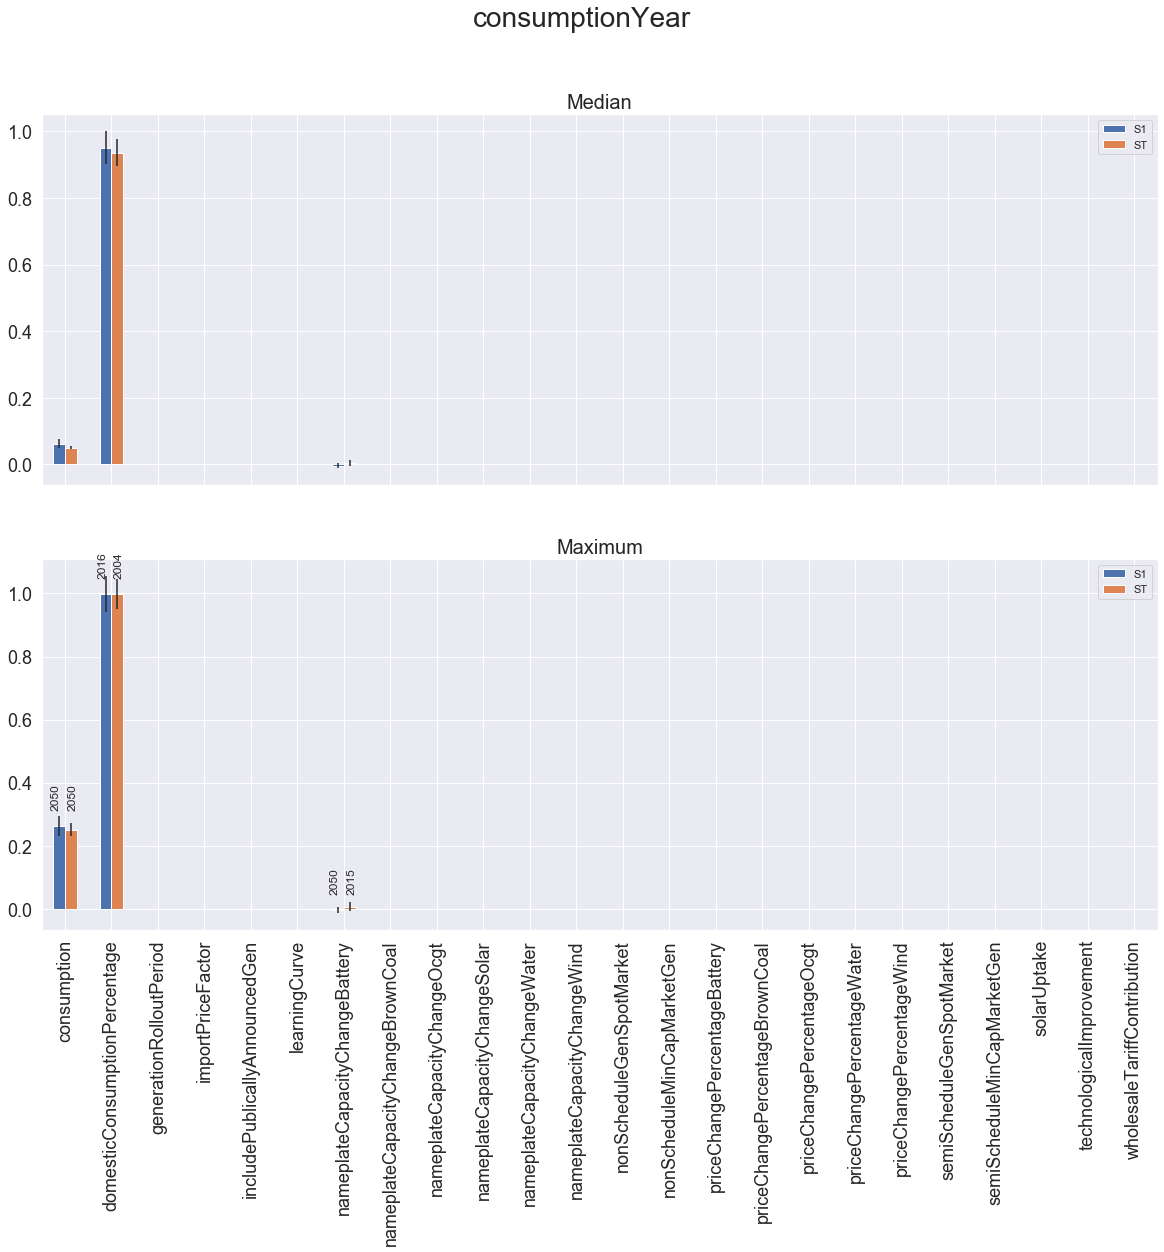

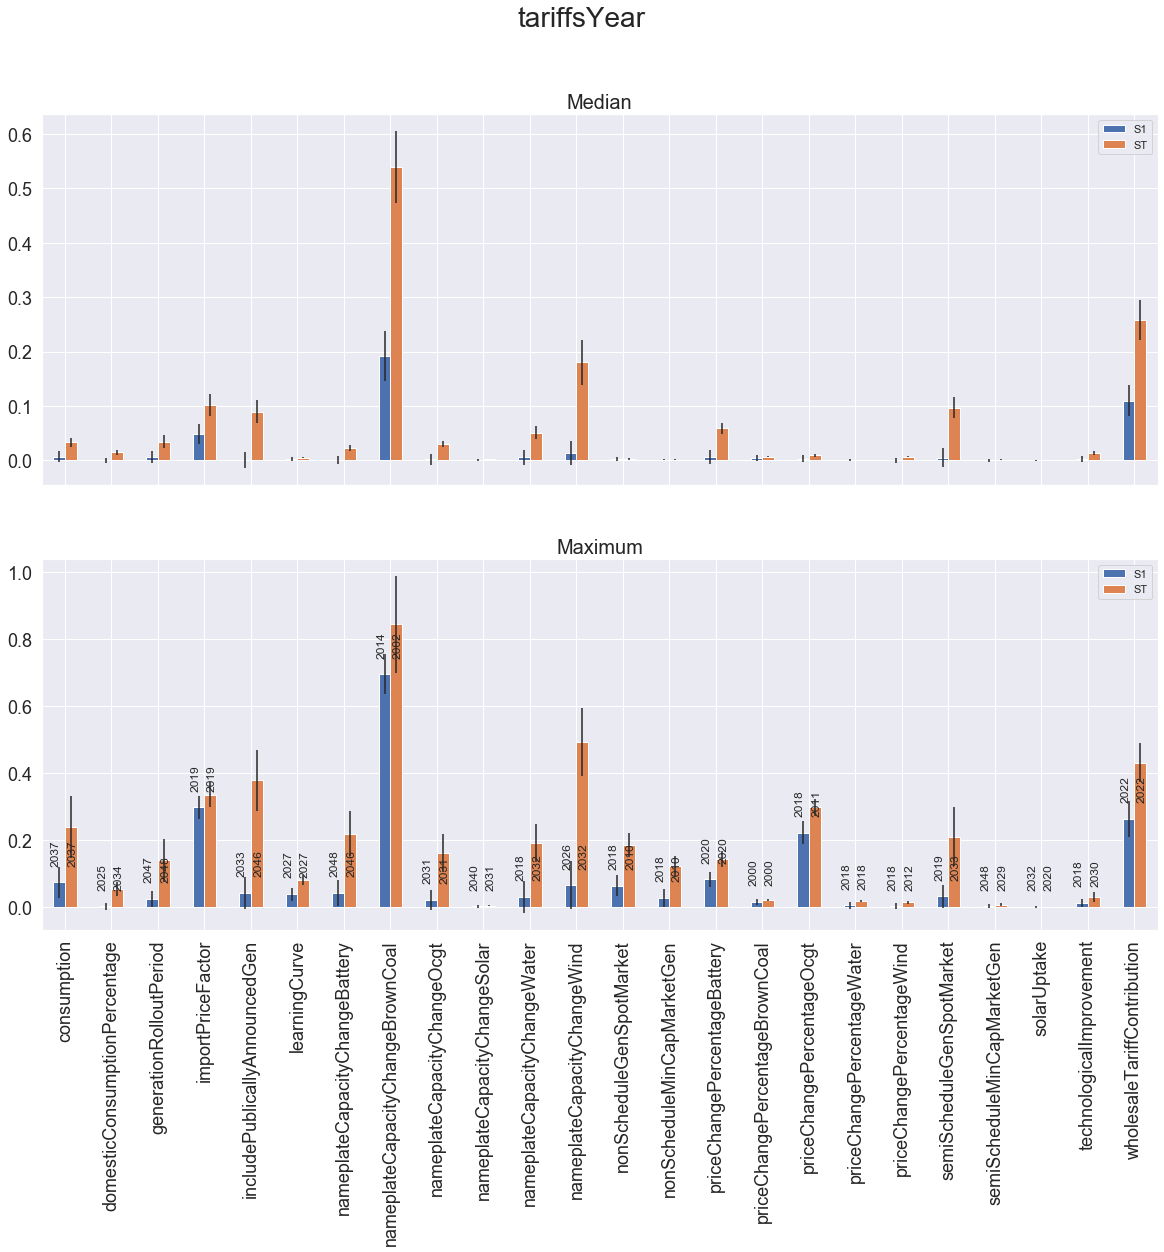

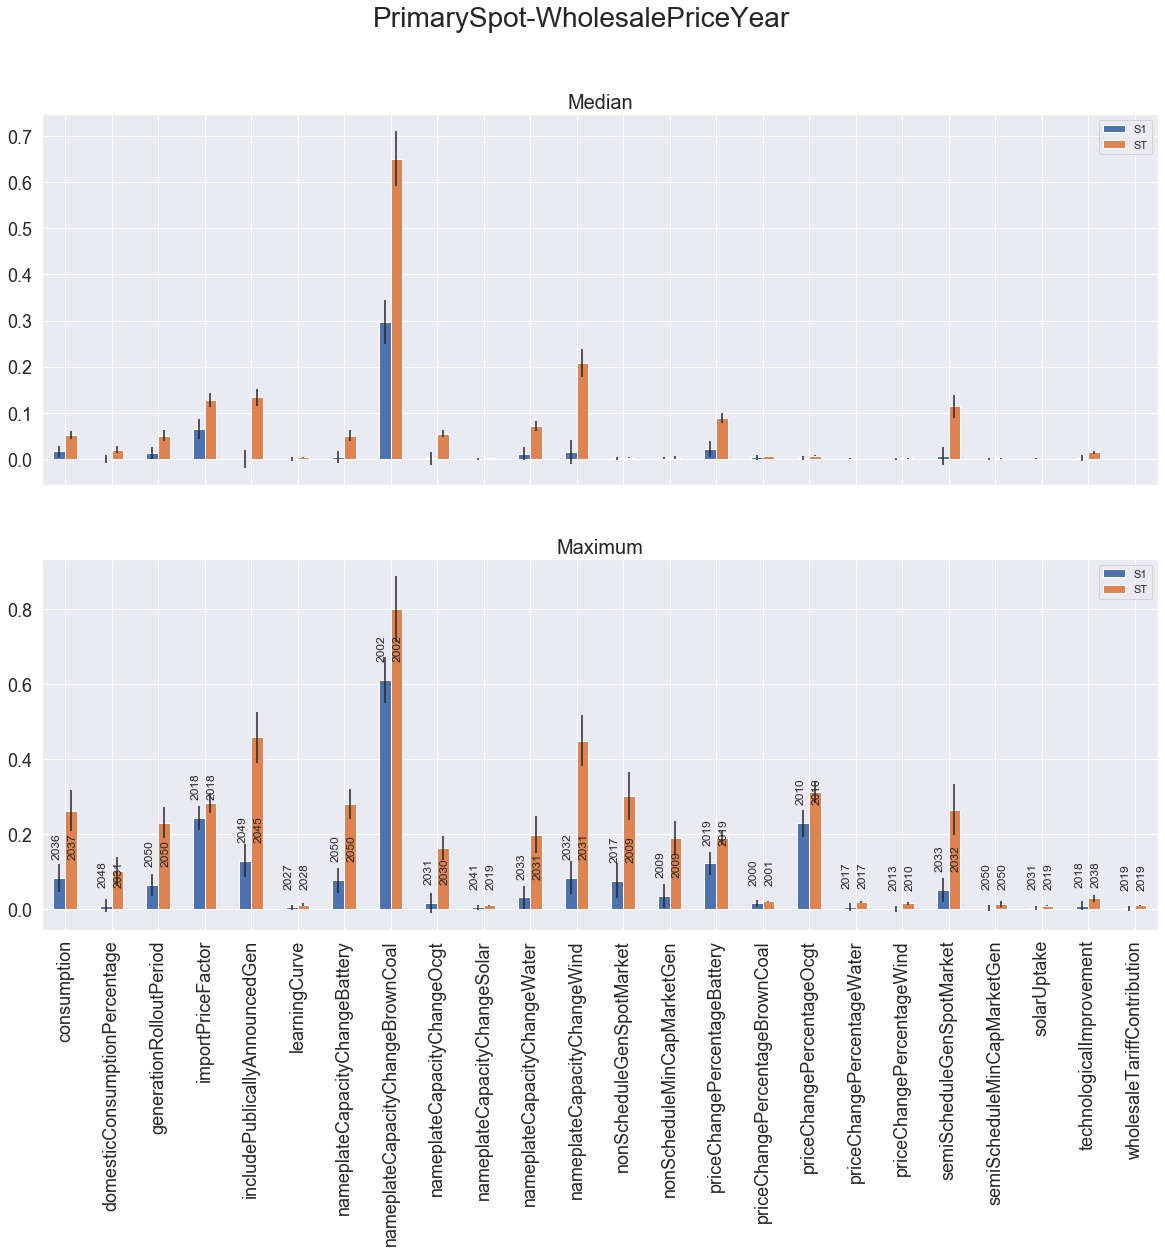

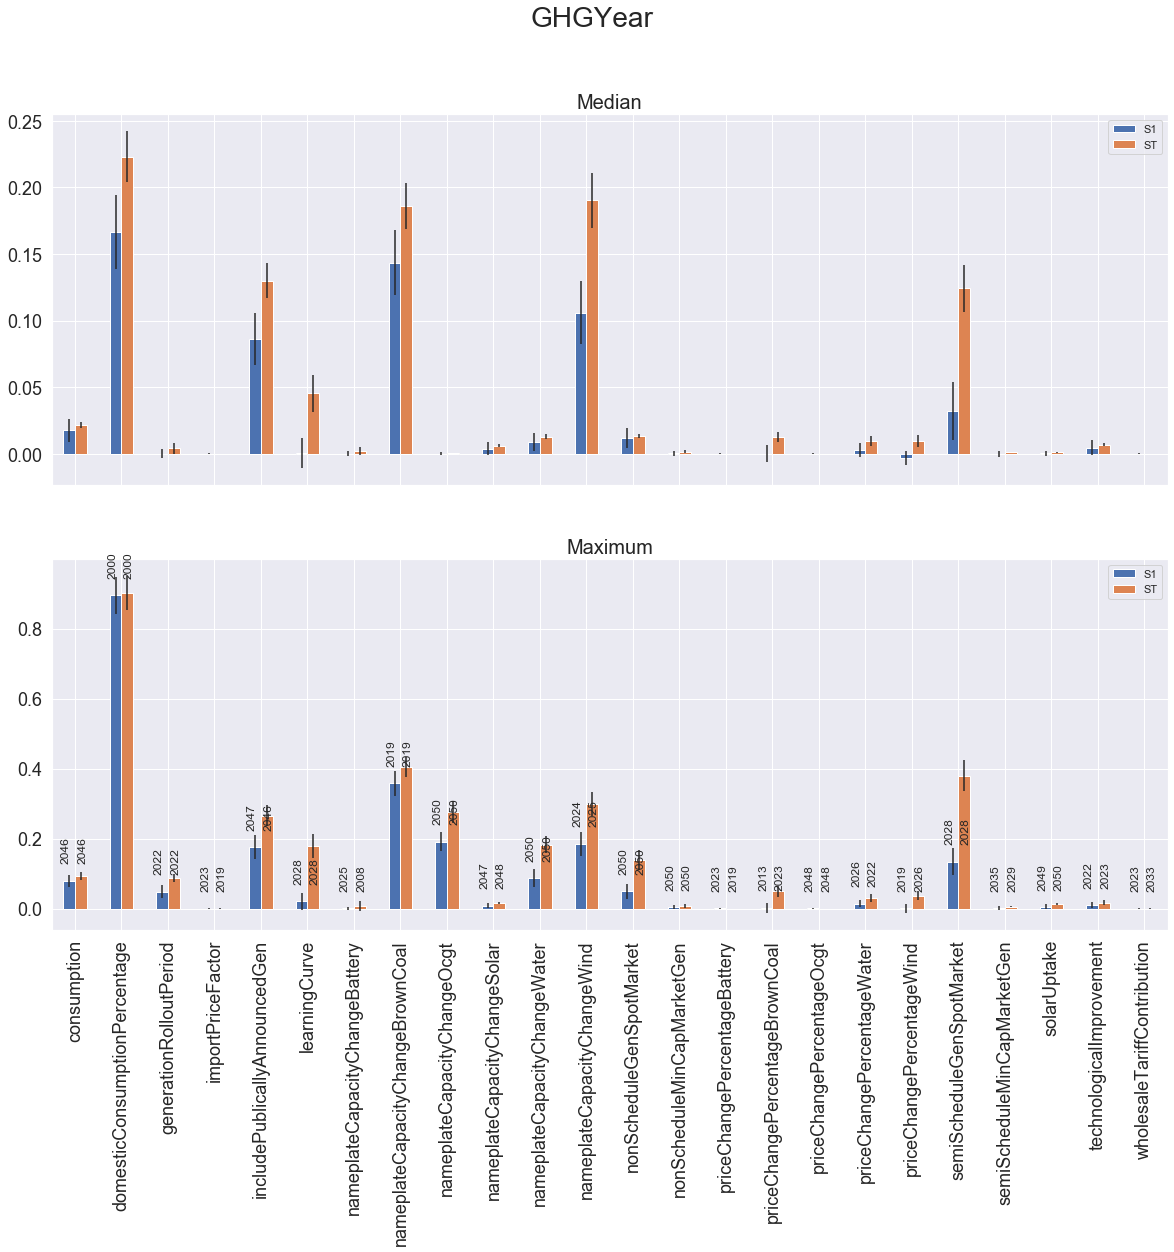

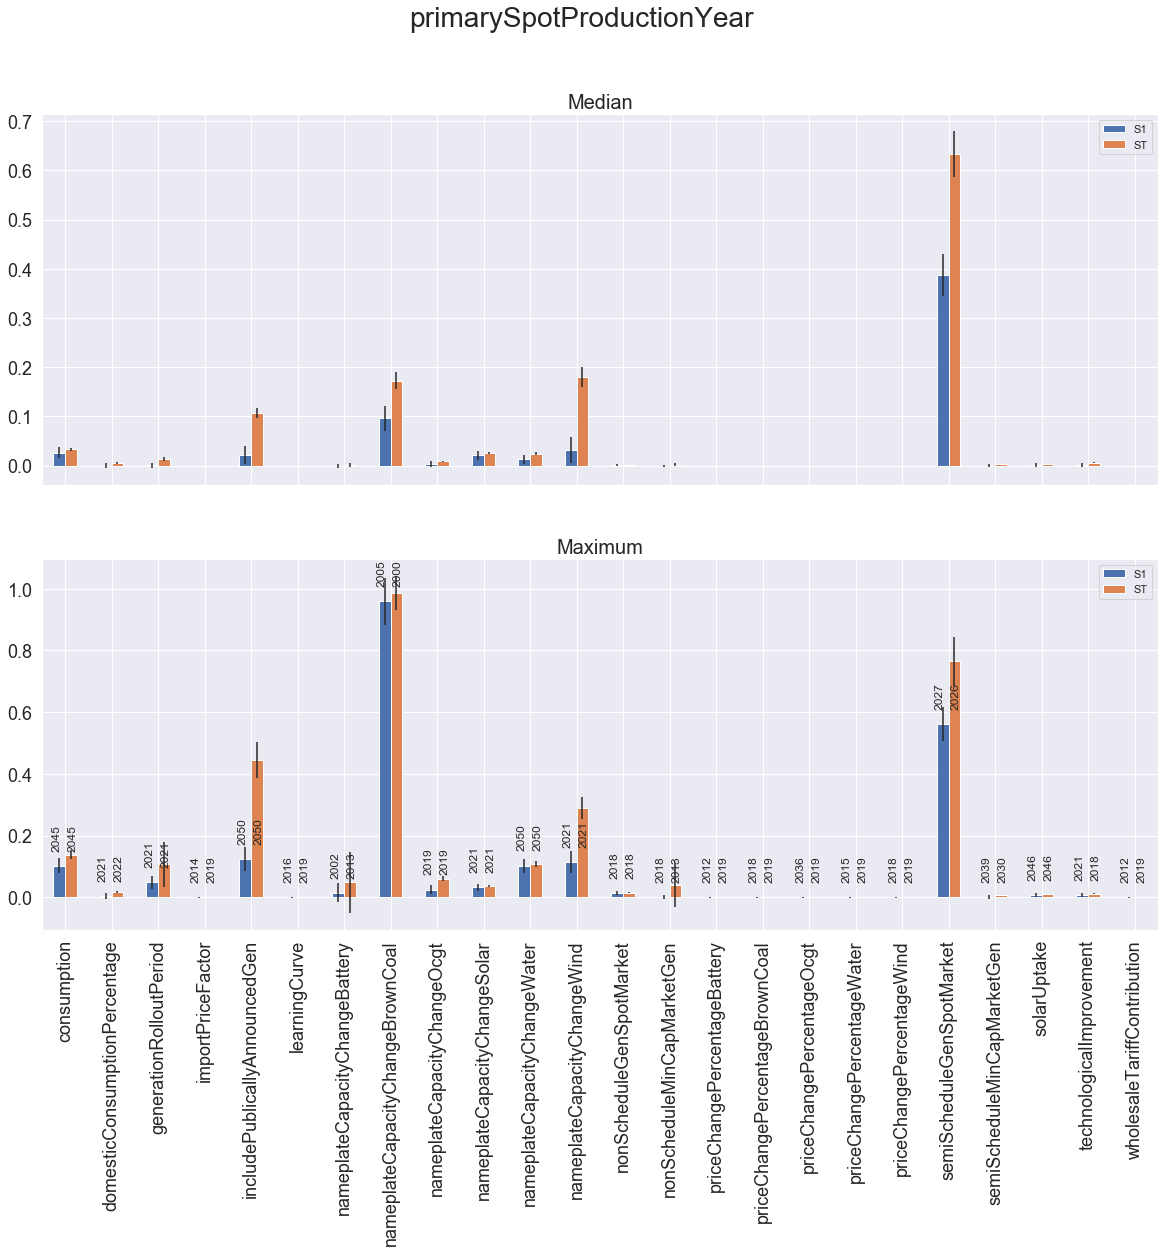

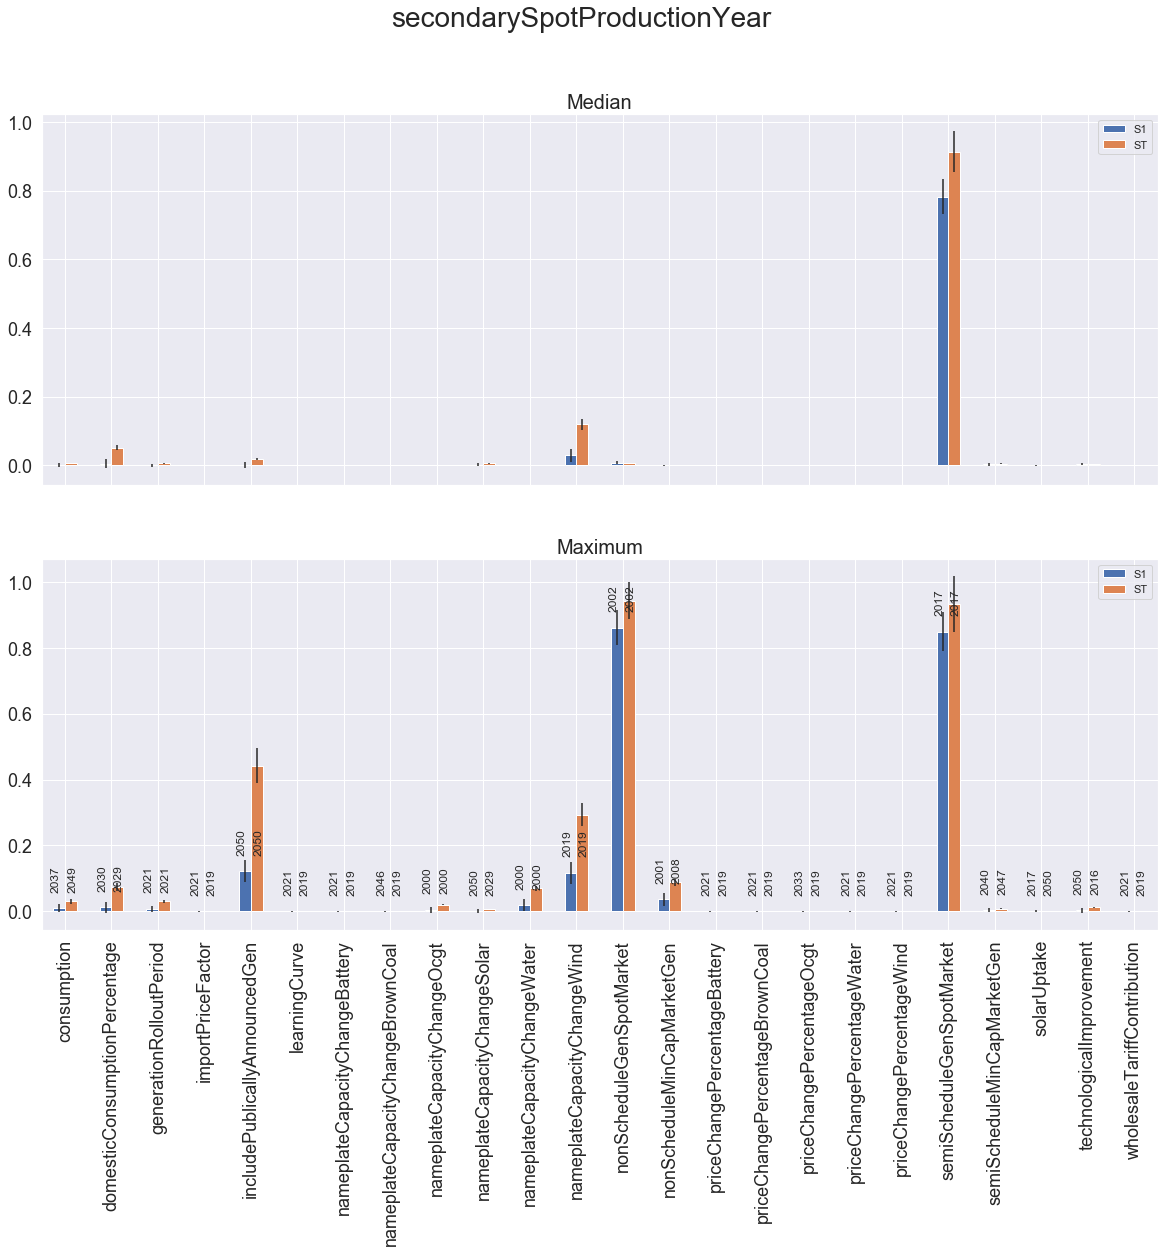

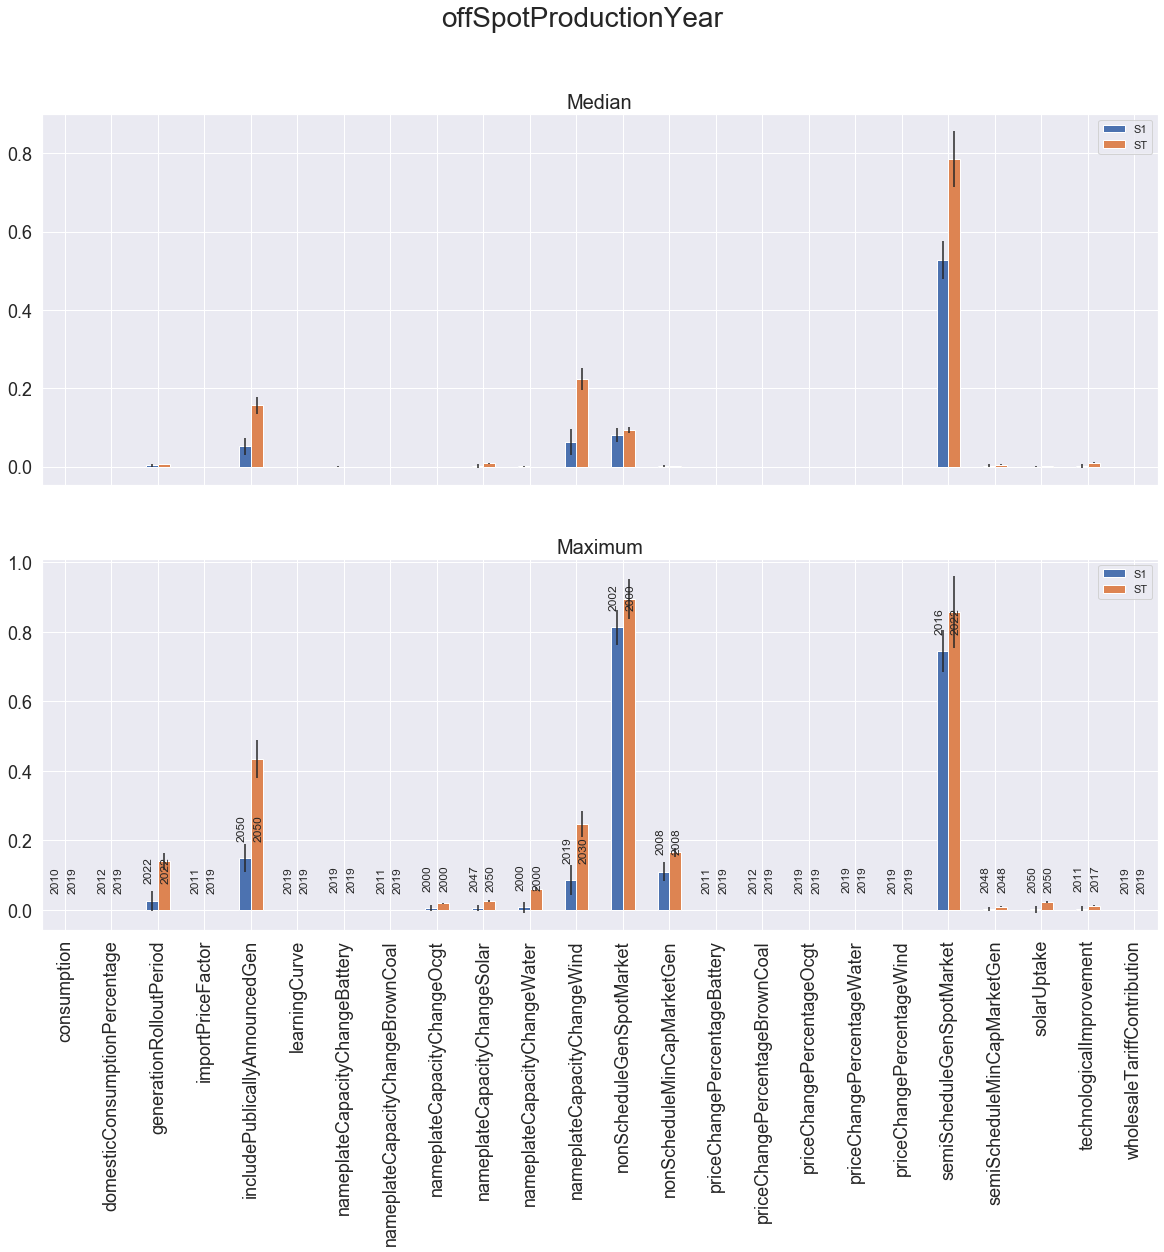

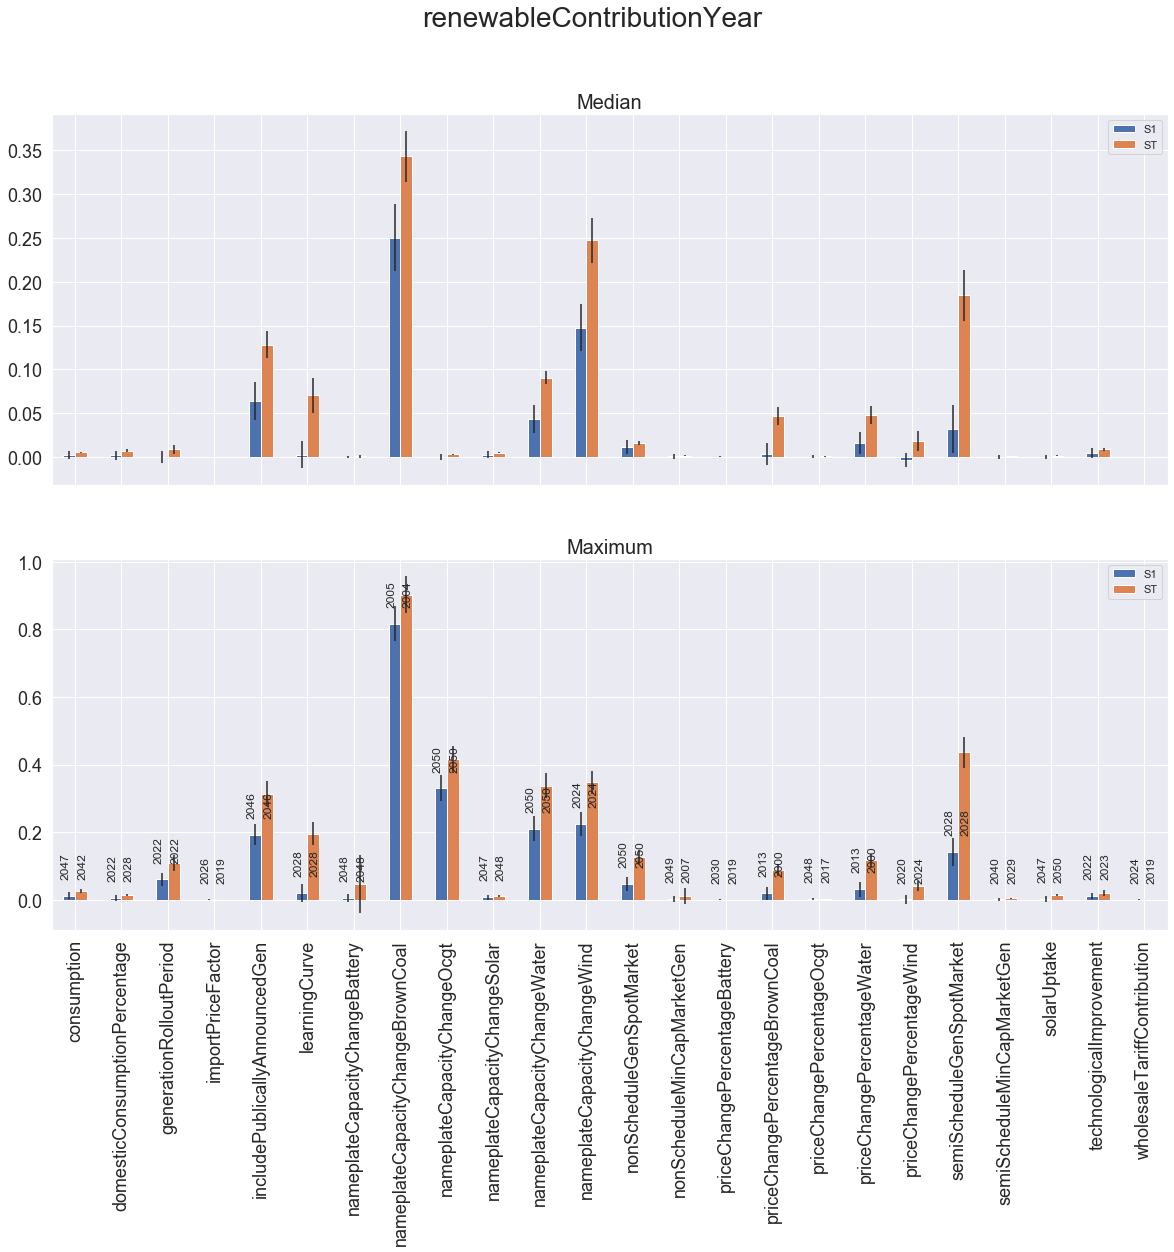

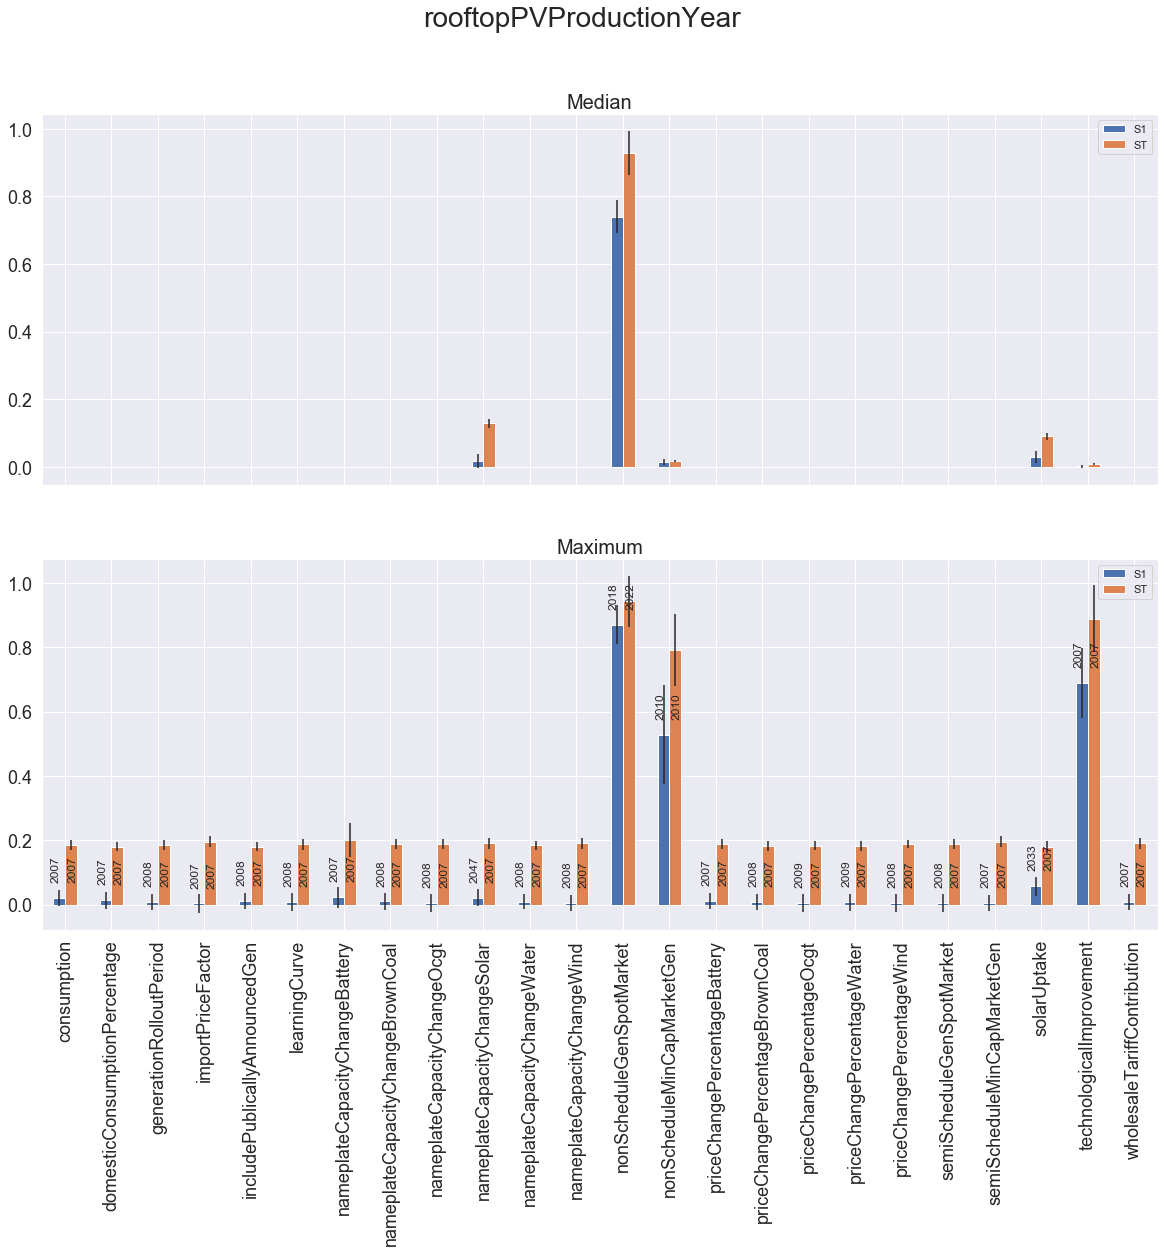

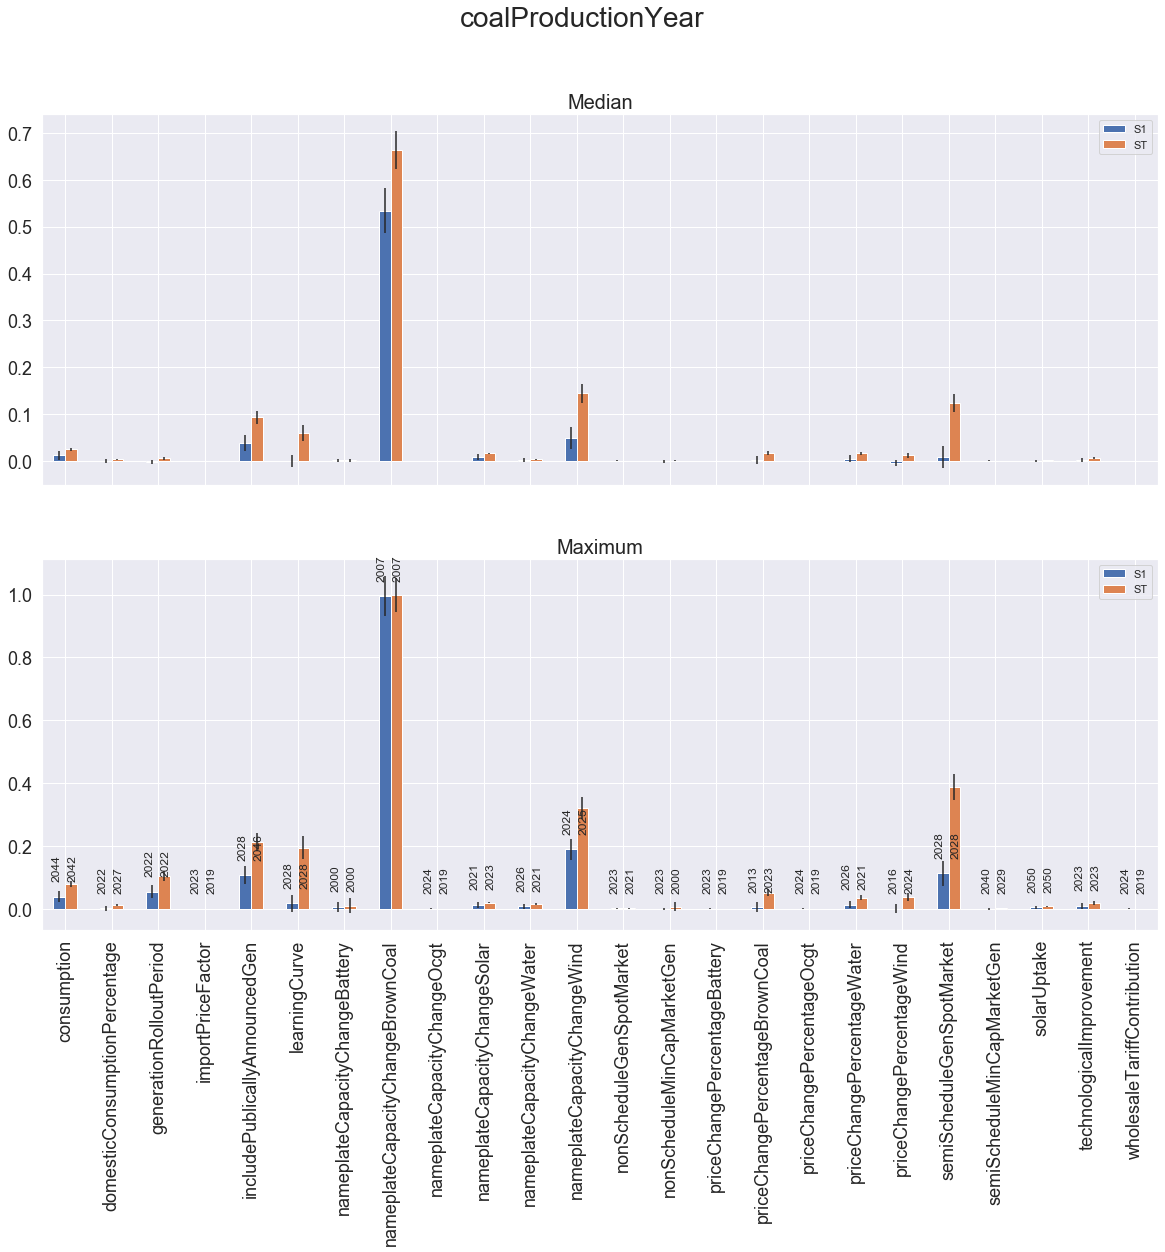

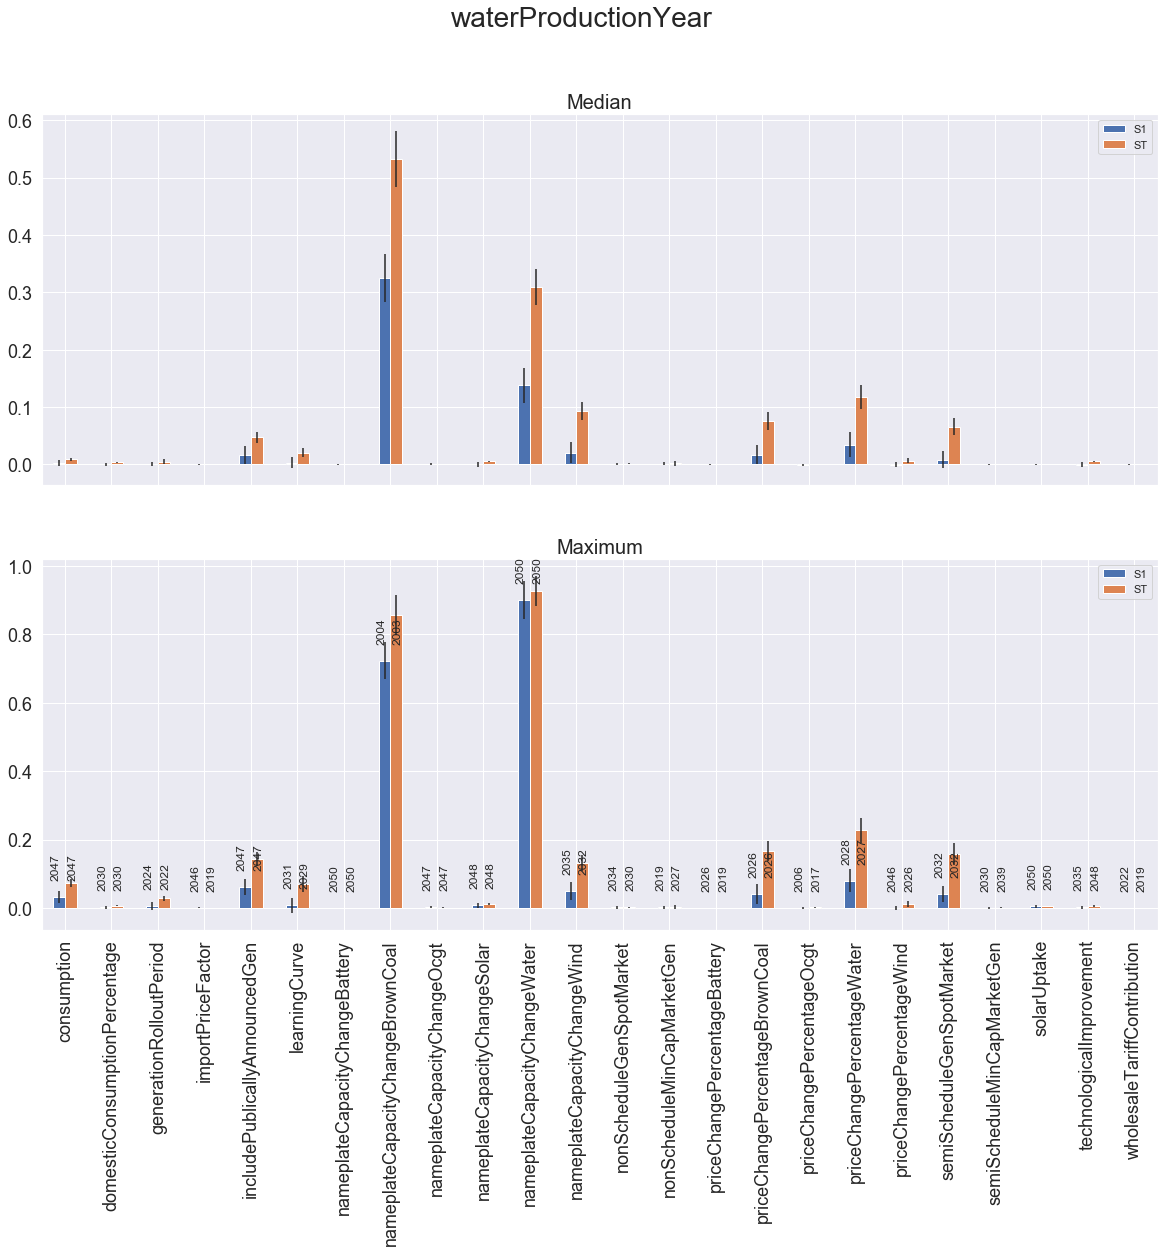

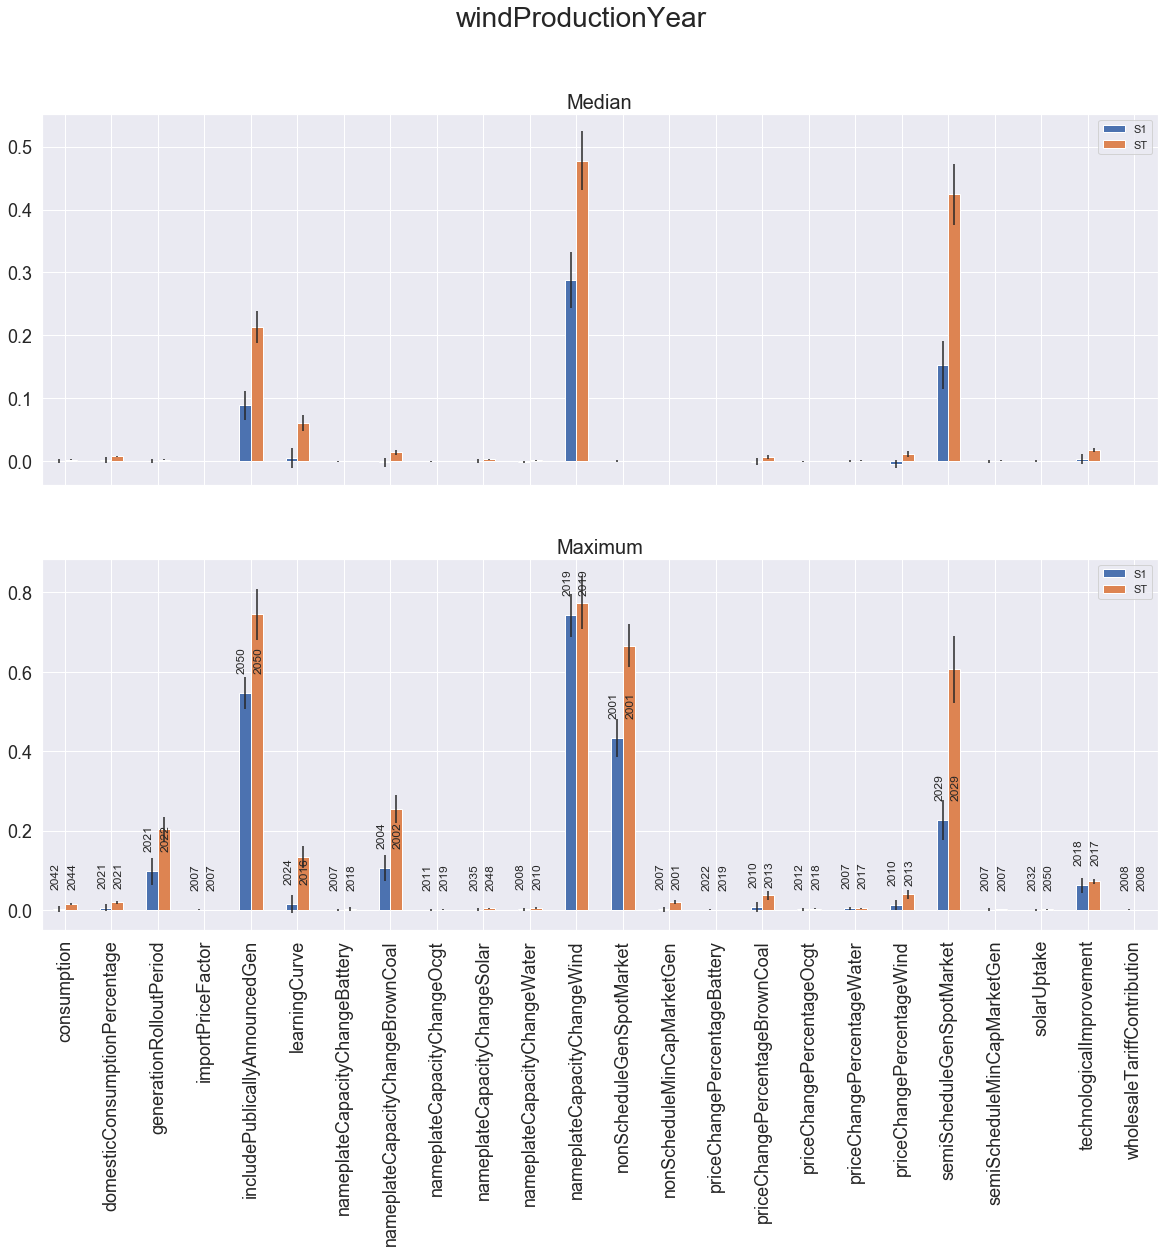

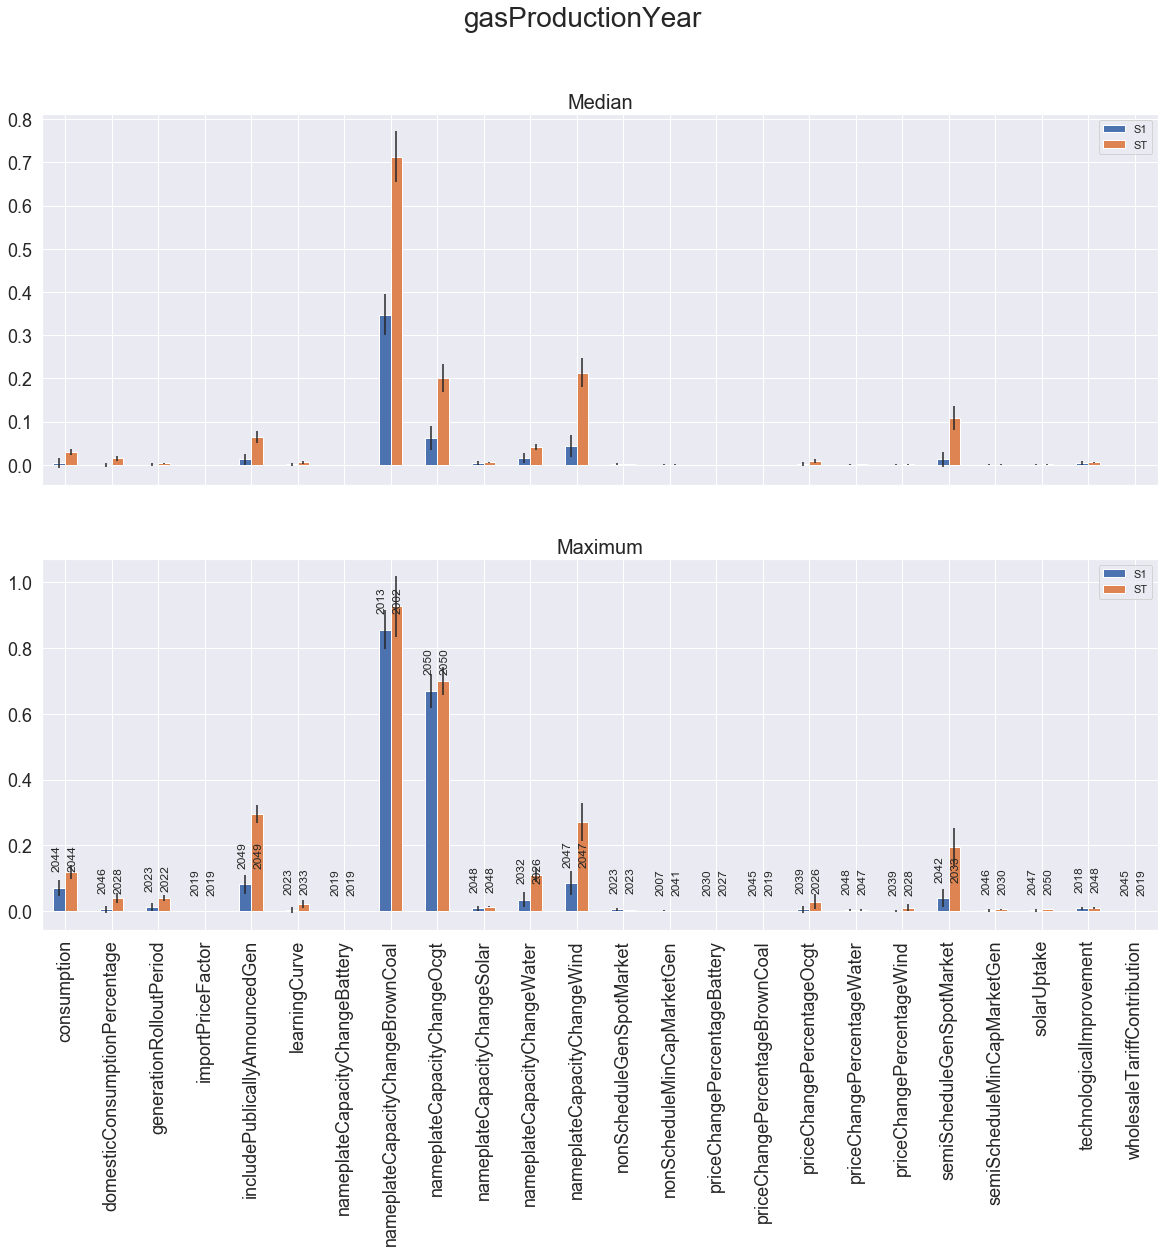

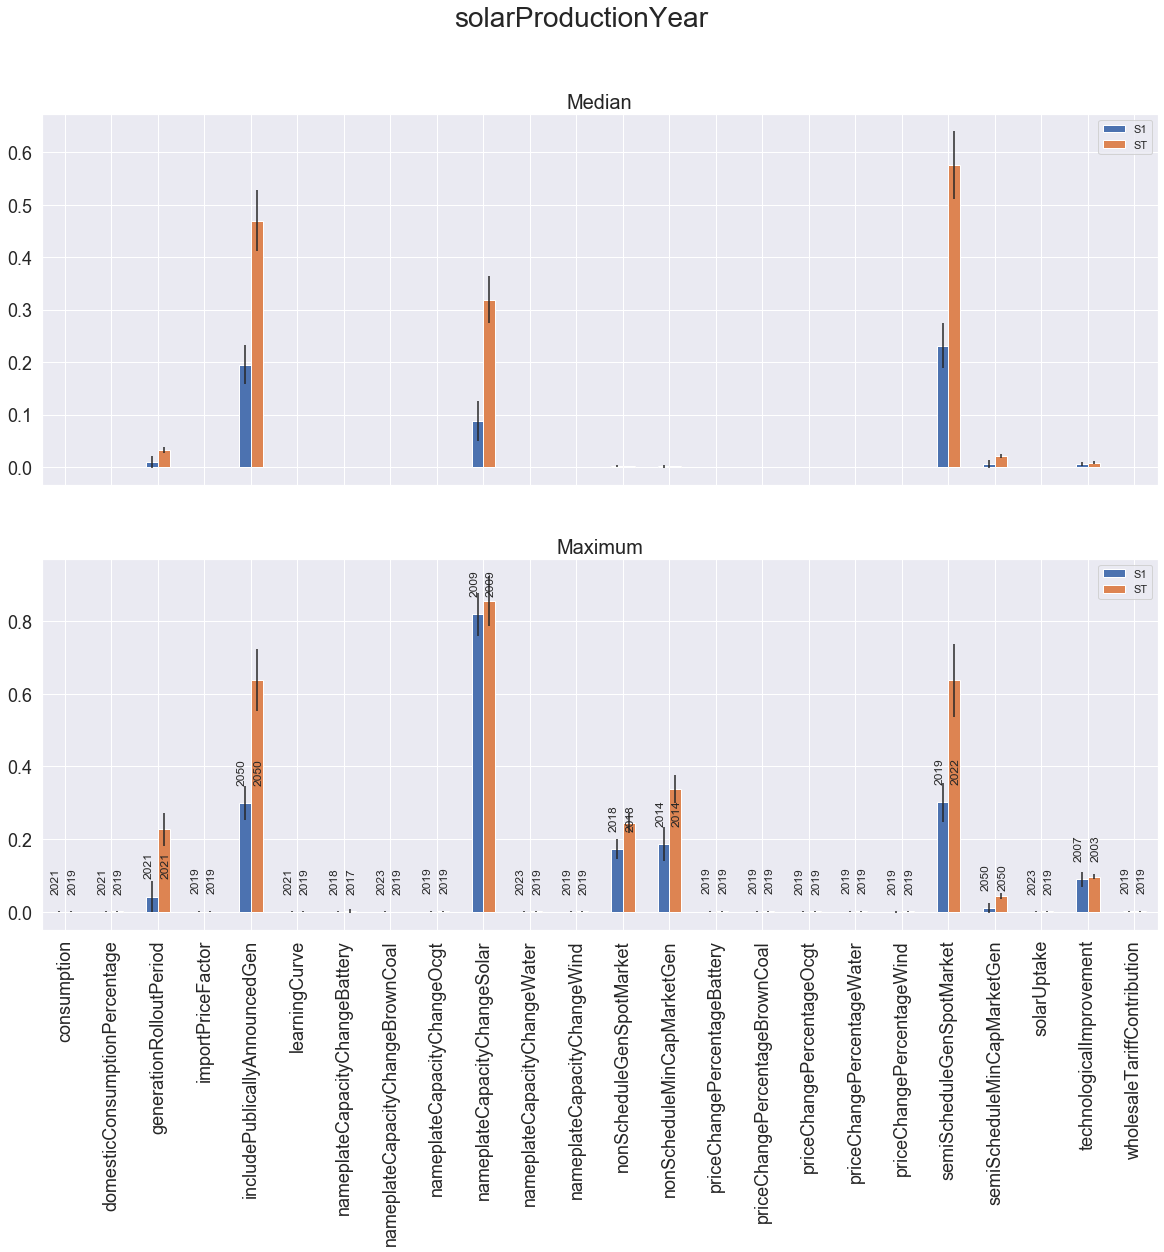

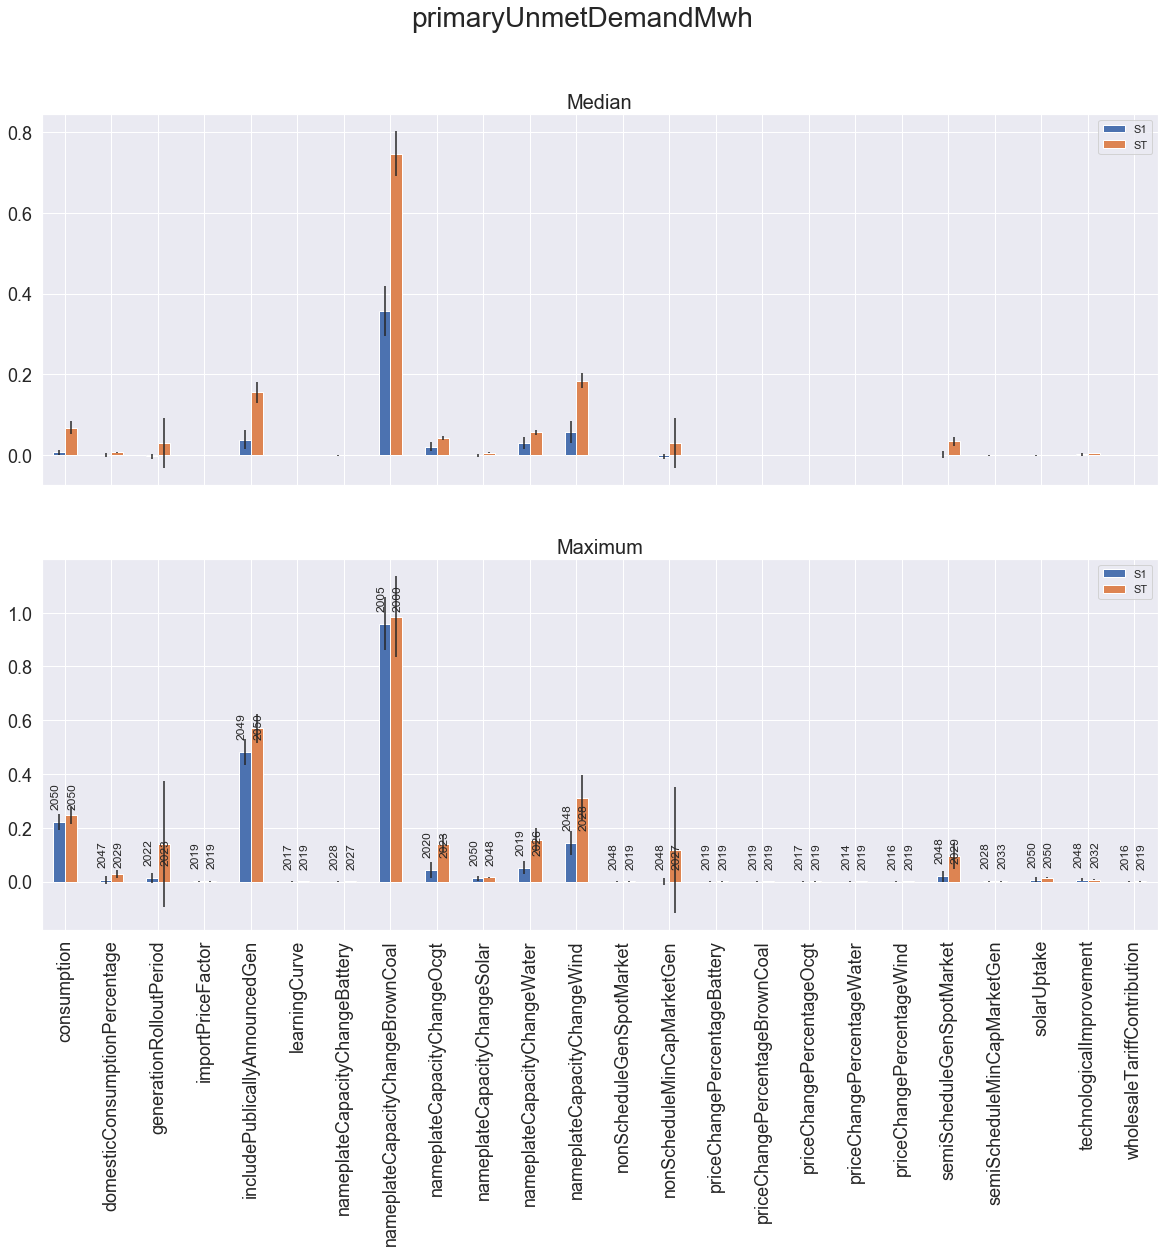

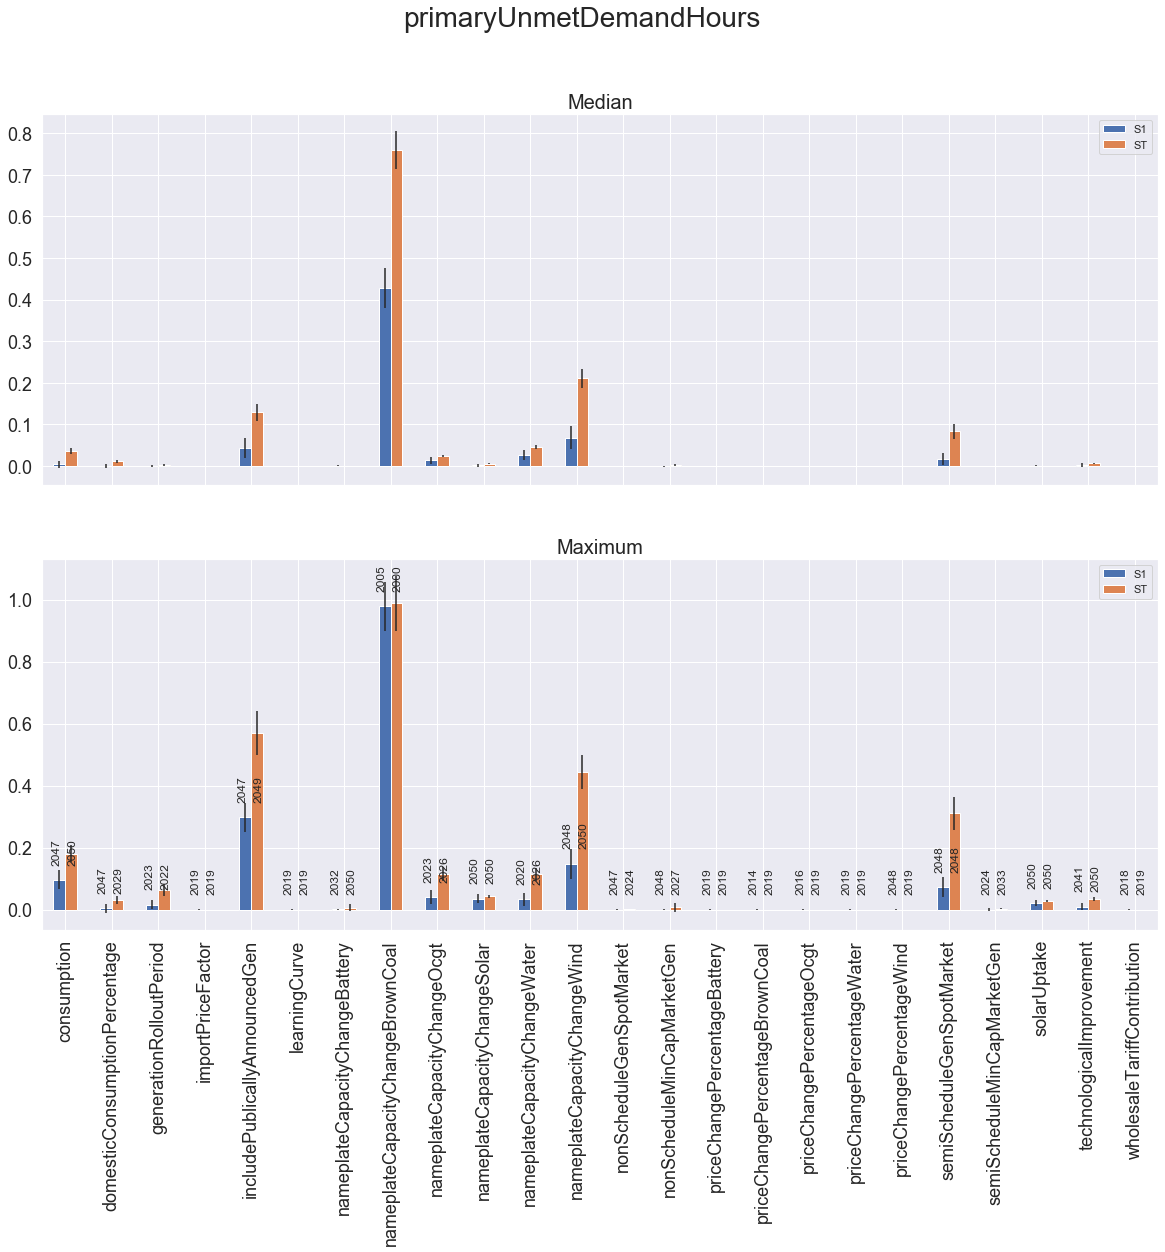

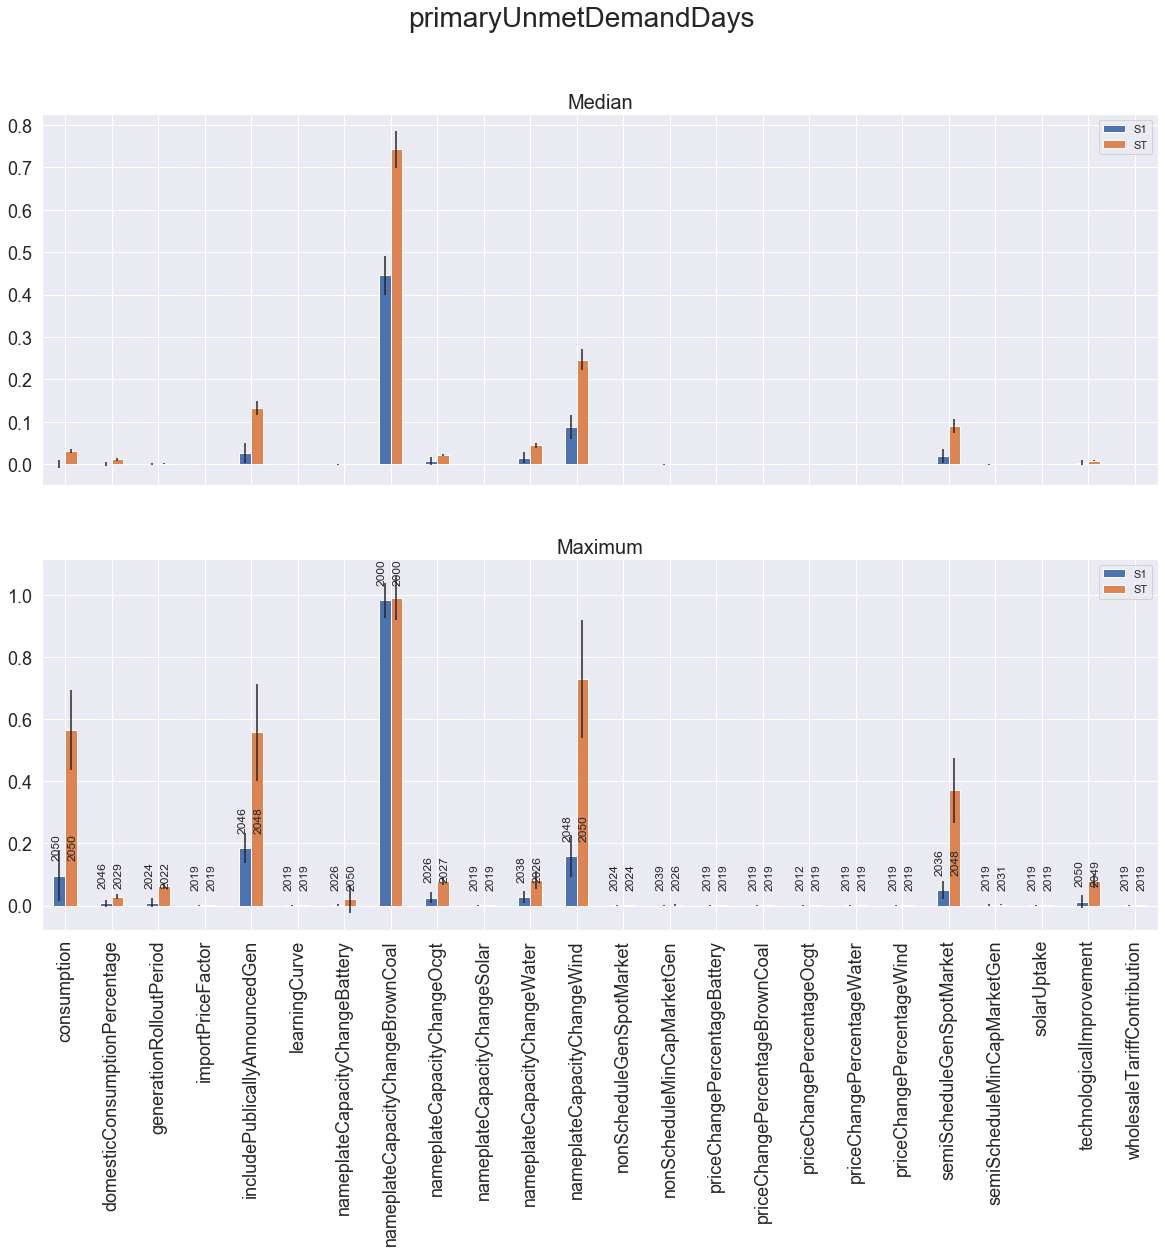

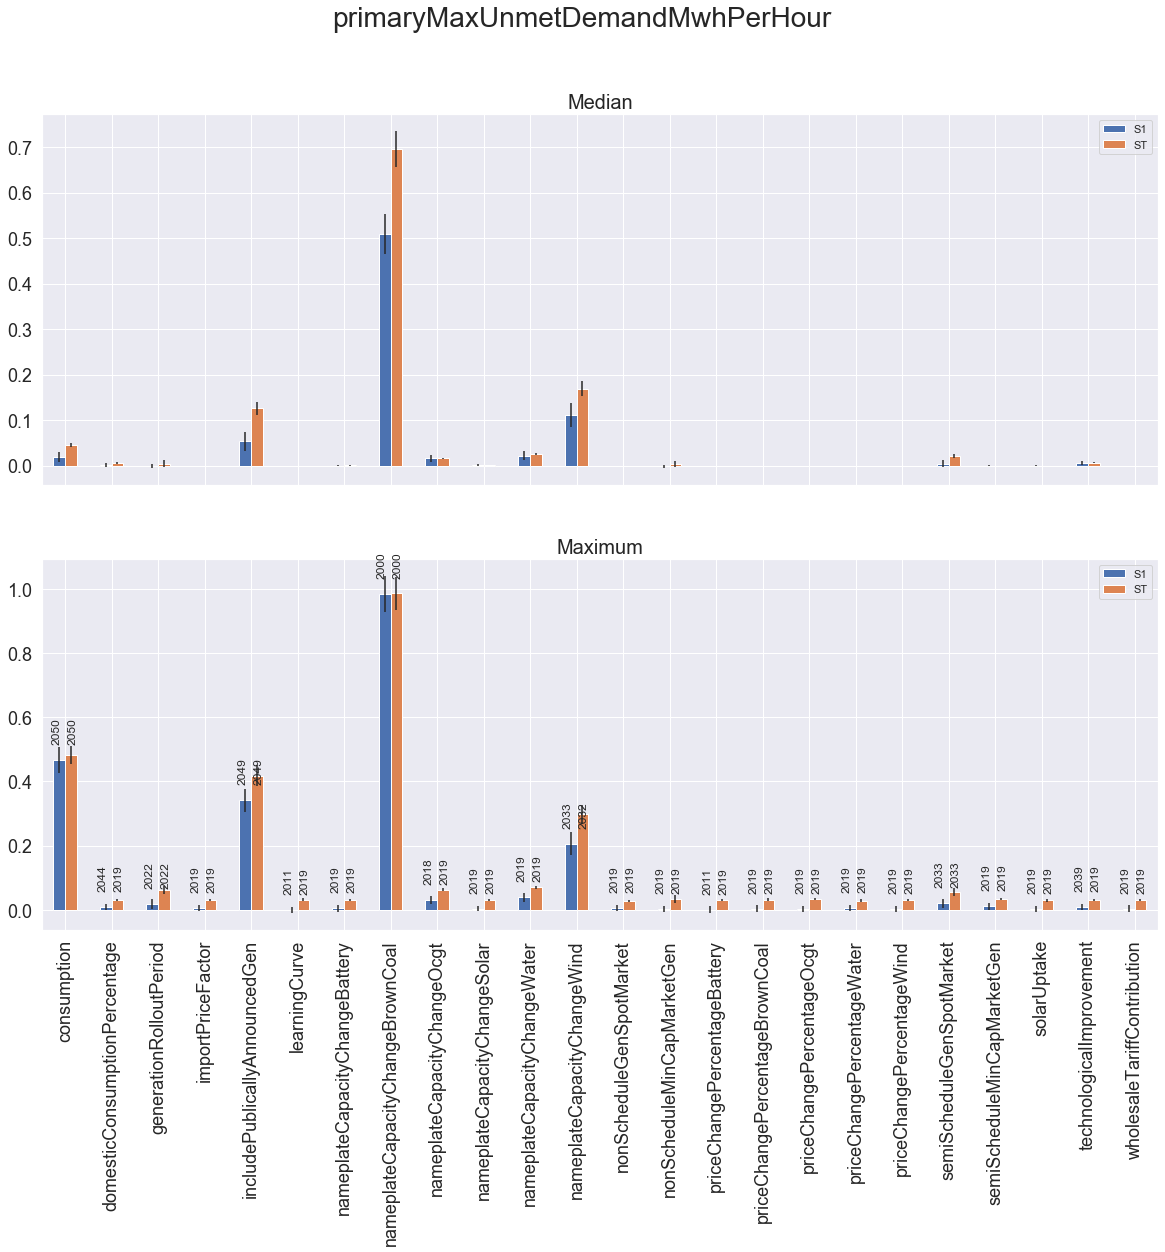

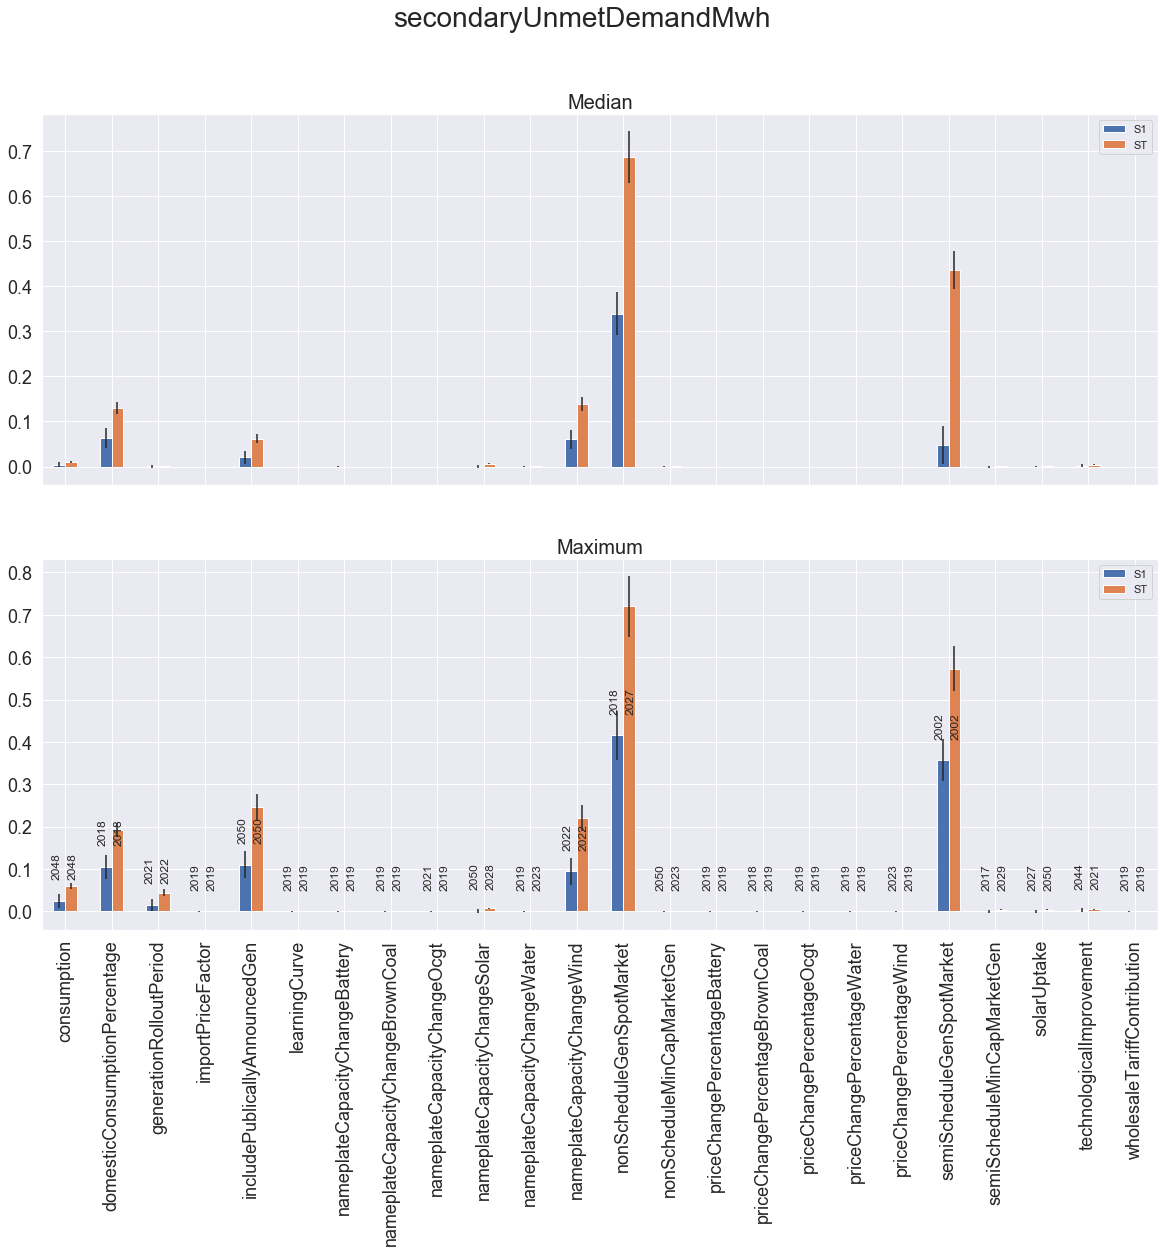

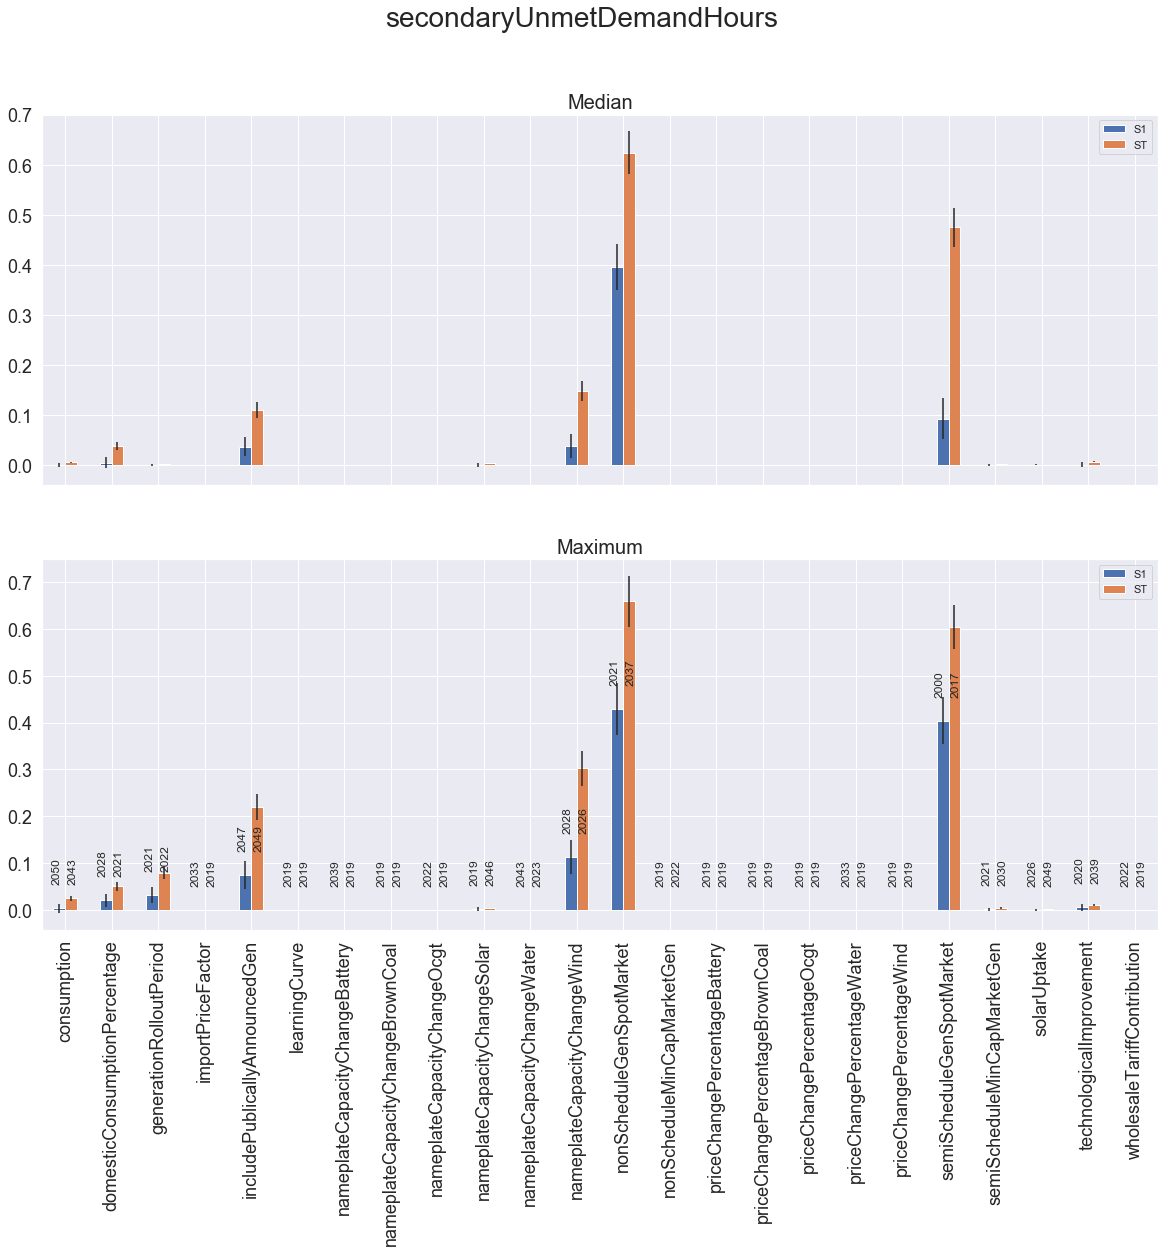

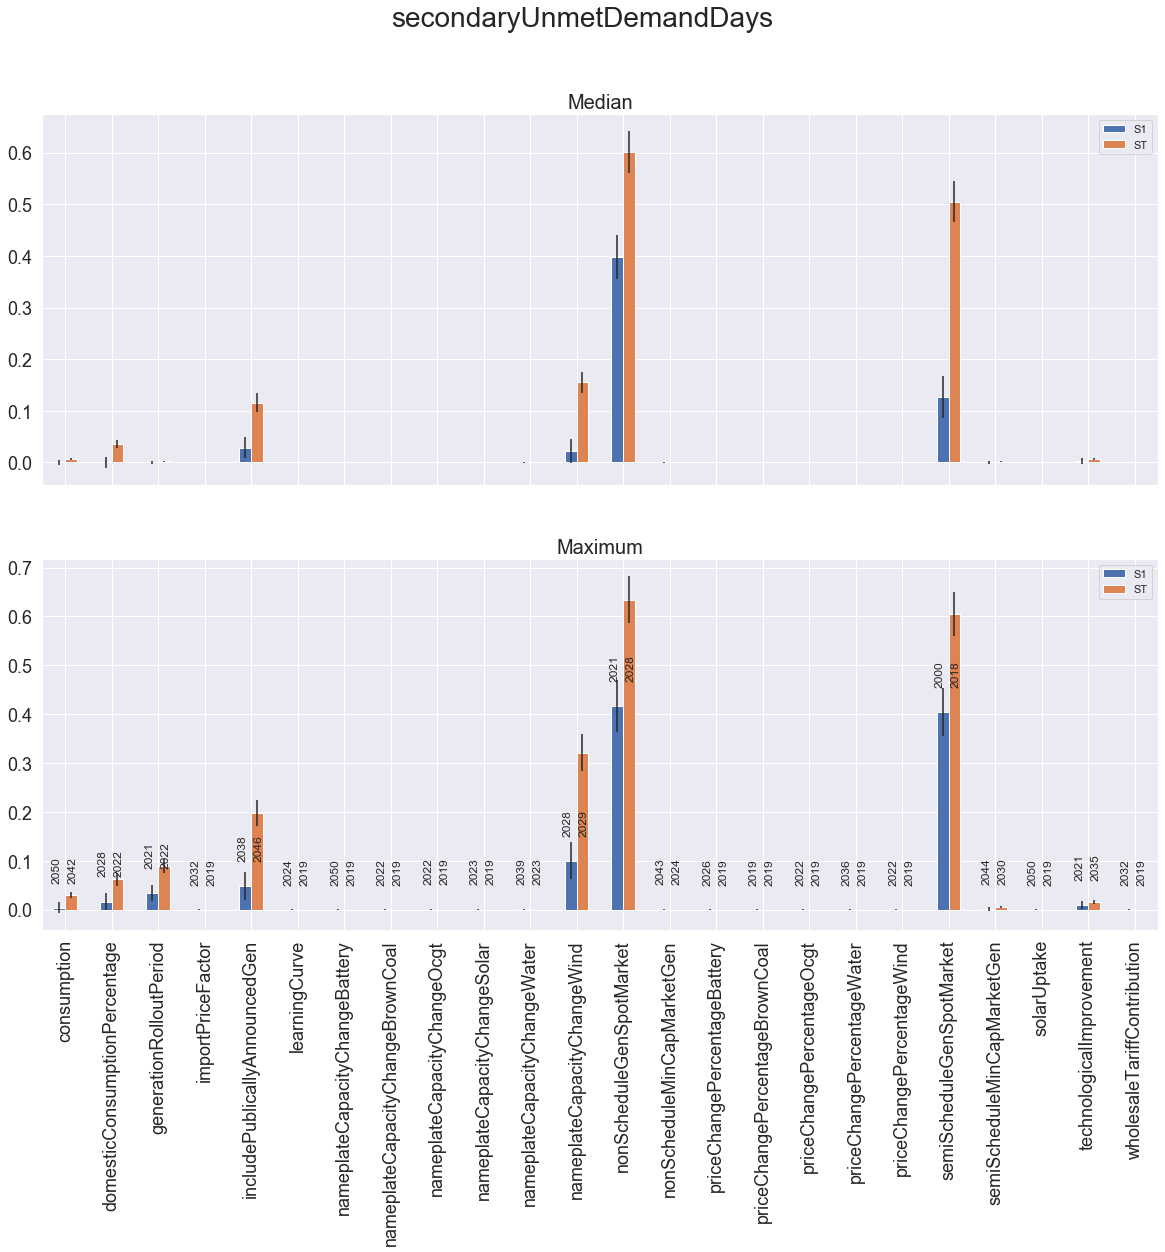

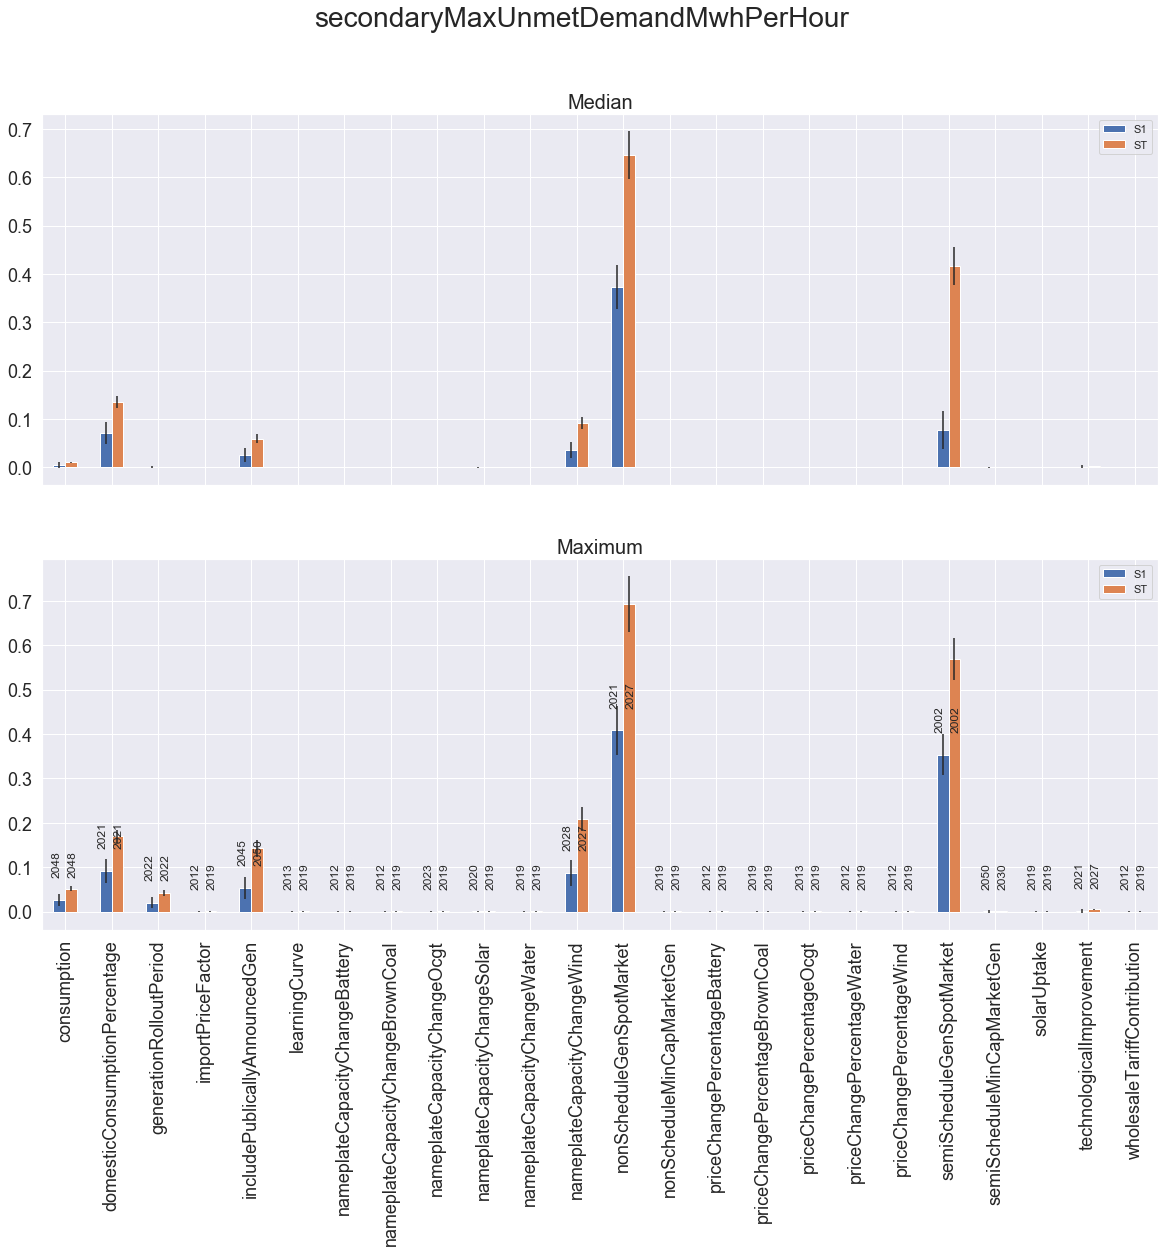

In [11]:
import seaborn as sns; sns.set()

writer = pd.ExcelWriter('{}/SOBOL_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_past_median_sensitivity_Indices'), engine='xlsxwriter')

for ooi in outcomes_to_show:
    
    Si_df_median = pd.concat({'S1': s1_median_ooi[ooi],'ST': st_median_ooi[ooi], 'S2': s2_median_ooi[ooi],'S1_conf': s1_conf_median_ooi[ooi],'ST_conf': st_conf_median_ooi[ooi], 'S2_conf': s2_conf_median_ooi[ooi]}, axis=1)
    Si_df_max = pd.concat({'S1': s1_max_val_ooi[ooi],'ST': st_max_val_ooi[ooi], 'S2': s2_max_val_ooi[ooi],'S1_conf': s1_conf_max_val_ooi[ooi],'ST_conf': st_conf_max_val_ooi[ooi], 'S2_conf': s2_conf_max_val_ooi[ooi]}, axis=1)
    
    if includePlots:
        fig, ax = plt.subplots(2, sharex=True)
        fig.set_size_inches(20,15)
        fig.suptitle(ooi, fontsize=28)

        ax[0].set_title("Median", fontsize=20)
        ax[1].set_title("Maximum", fontsize=20)

        plt.xticks (fontsize = 18)
        plt.yticks (fontsize = 18)
        ax[0].tick_params(labelsize=18)

        indices_median = Si_df_median[['S1','ST']]
        err_median = Si_df_median[['S1_conf','ST_conf']]

        indices_max = Si_df_max[['S1','ST']]
        err_max = Si_df_max[['S1_conf','ST_conf']]

        
        indices_median.plot.bar(yerr=err_median.values.T,ax=ax[0])
        indices_max.plot.bar(yerr=err_max.values.T,ax=ax[1])
        for p, text_s1, text_st in zip(ax[1].patches, s1_max_val_year_ooi[ooi], st_max_val_year_ooi[ooi]):
            if p.get_height() != 0:
                ax[1].annotate(str(text_s1), (p.get_x() - 0.05, p.get_height() + .055) ,fontsize=12, rotation='vertical')
                ax[1].annotate(str(text_st), (p.get_x() + 0.3, p.get_height() + .055) ,fontsize=12,  rotation='vertical')
                               
        ax[0].legend(['S1','ST'])
        ax[1].legend(['S1','ST'])
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_past_barplot_s1_st_%s'%(ooi)),dpi=300, bbox_inches='tight')
        
    print(ooi)
    #break
    if ooi == 'secondaryMaxUnmetDemandMwhPerHour':
        ooi = 'secondMaxUnmetMwhPerHour'
        
    Si_df_median.to_excel(writer, sheet_name=ooi)

    
    

writer.save()

### S2 plots

In [12]:
# #%matplotlib inline
# sns.set_style('whitegrid')
# if includePlots:
#     for ooi in outcomes_to_show:

#         #Maximum
#         Si_df_max = {'S1': s1_max_val_ooi[ooi].to_numpy(),'S2': s2_max_val_ooi[ooi].to_numpy(),
#                      'ST': st_max_val_ooi[ooi].to_numpy(),'S1_conf': s1_conf_max_val_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_max_val_ooi[ooi].to_numpy(),'ST_conf': st_conf_max_val_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_max, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi)   

#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_max_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         #Median
#         Si_df_avg = {'S1': s1_median_ooi[ooi].to_numpy(),'S2': s2_median_ooi[ooi].to_numpy(),
#                      'ST': st_median_ooi[ooi].to_numpy(),'S1_conf': s1_conf_median_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_median_ooi[ooi].to_numpy(),'ST_conf': st_conf_median_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_median, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi, fontsize=16)   



#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_median_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         print(ooi)
     

C:\Users\angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


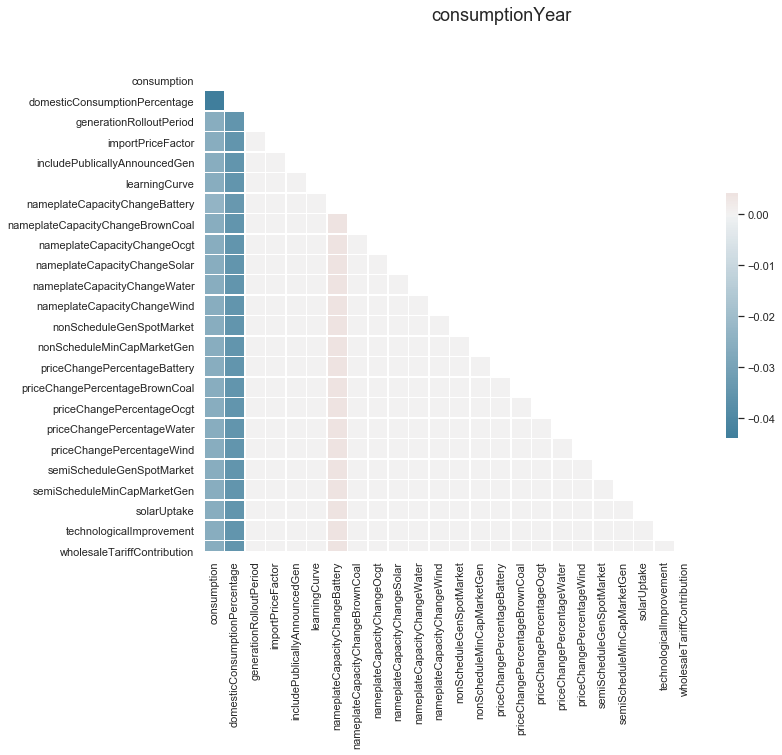

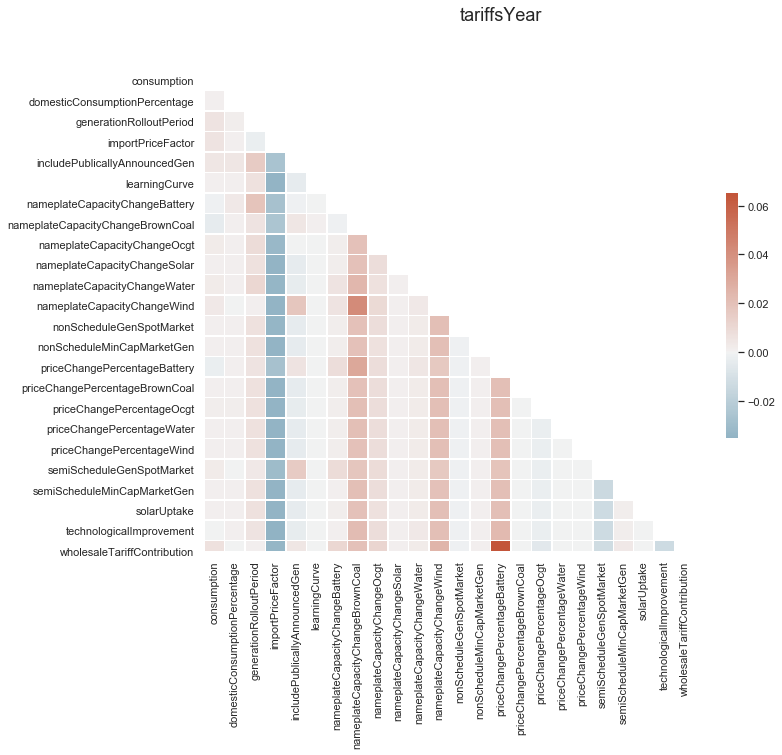

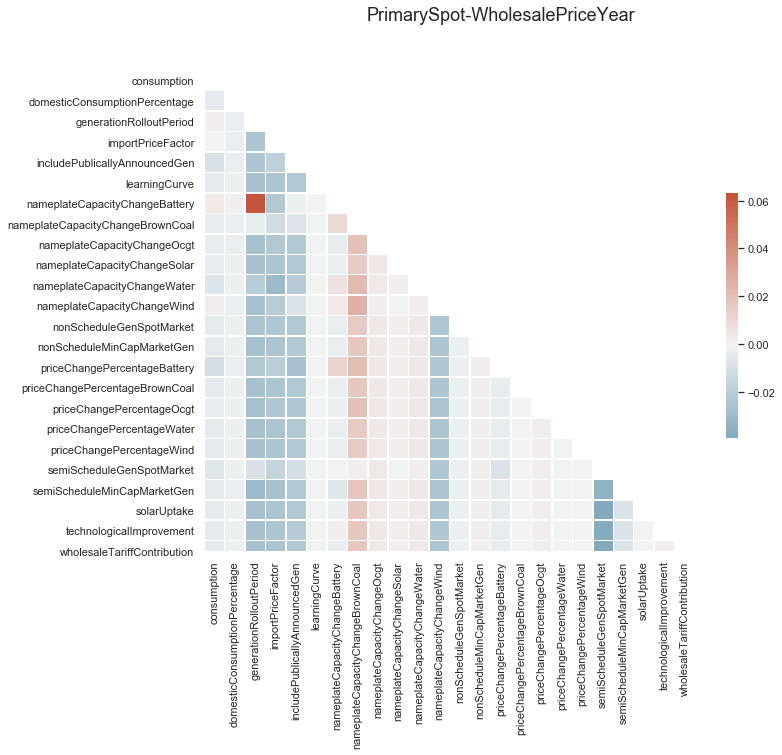

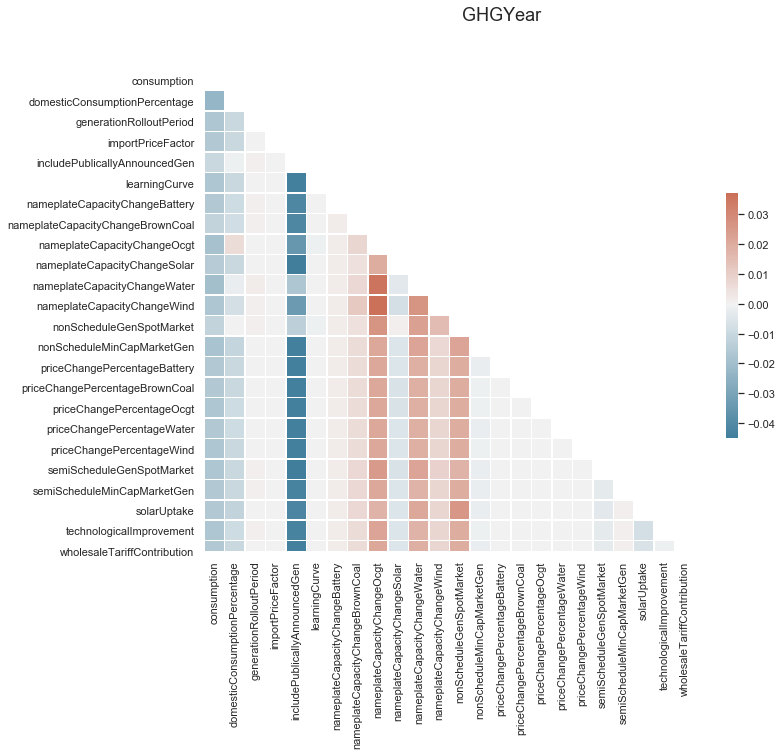

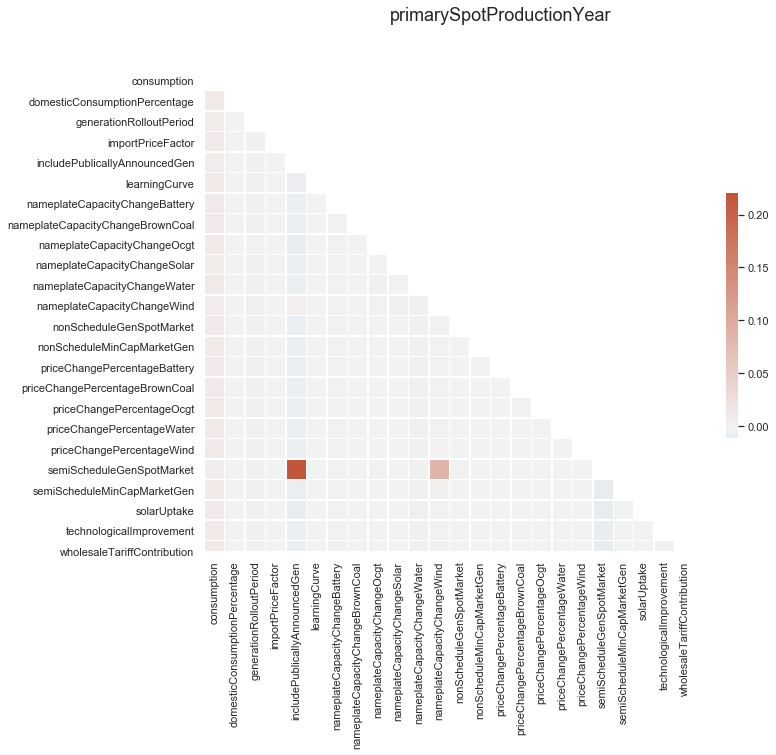

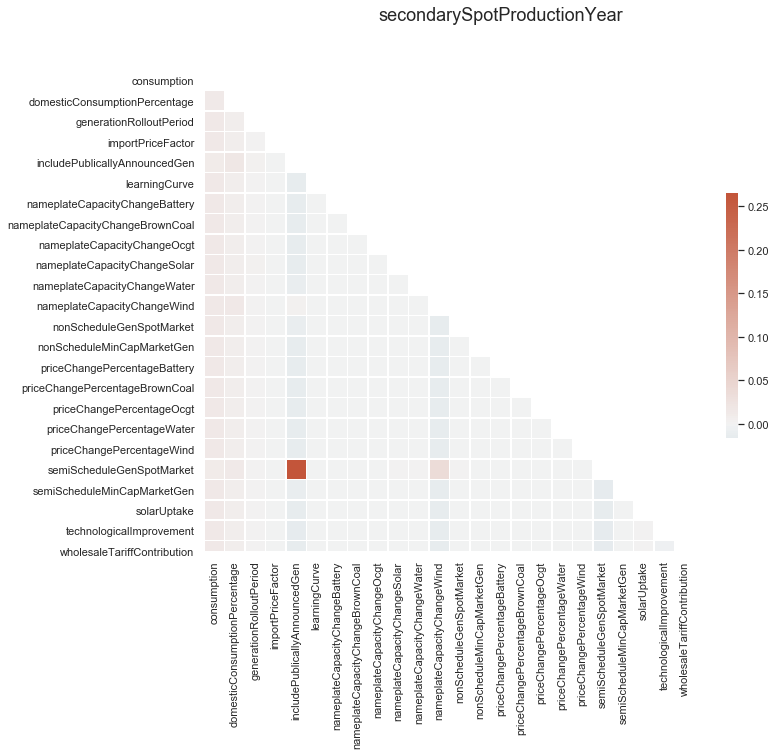

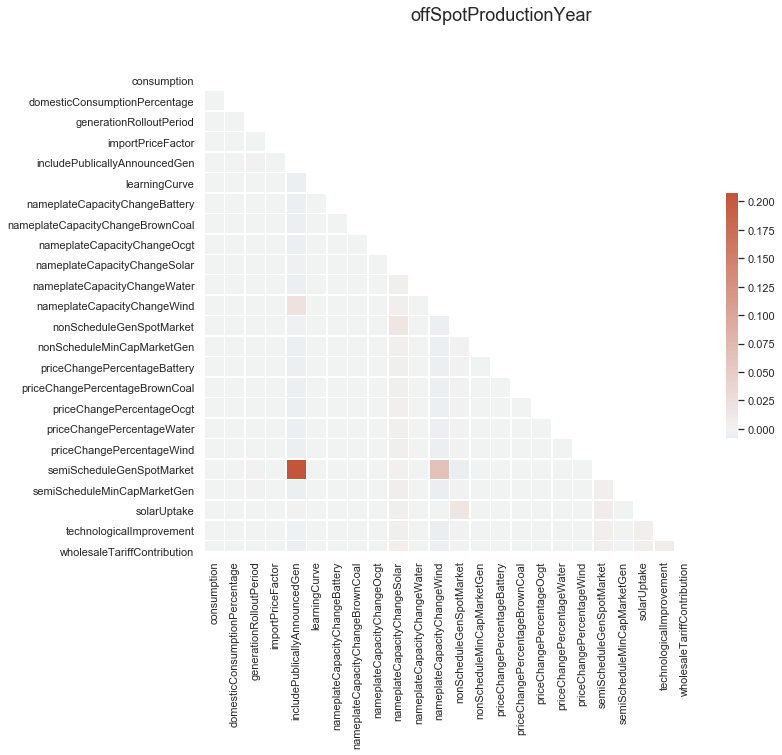

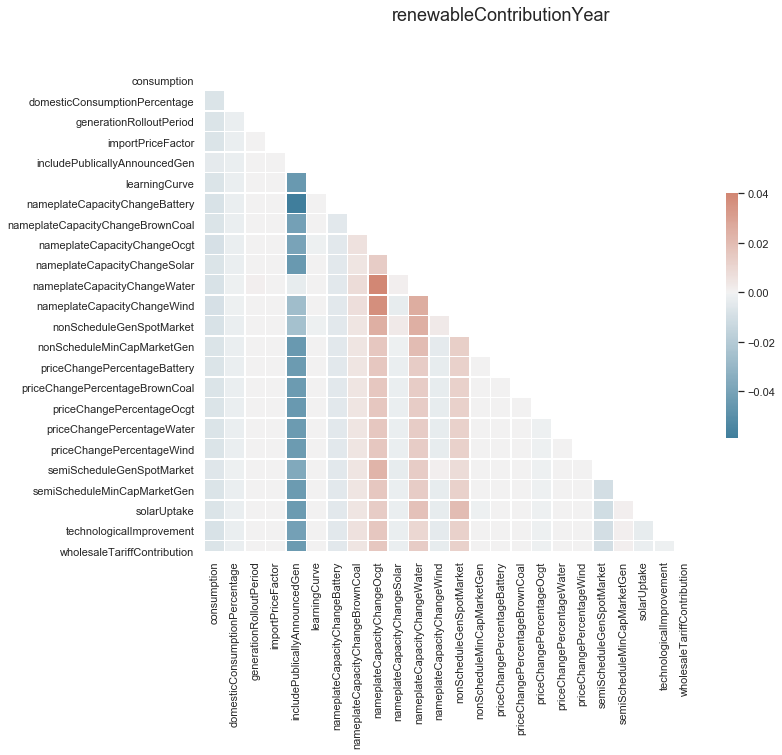

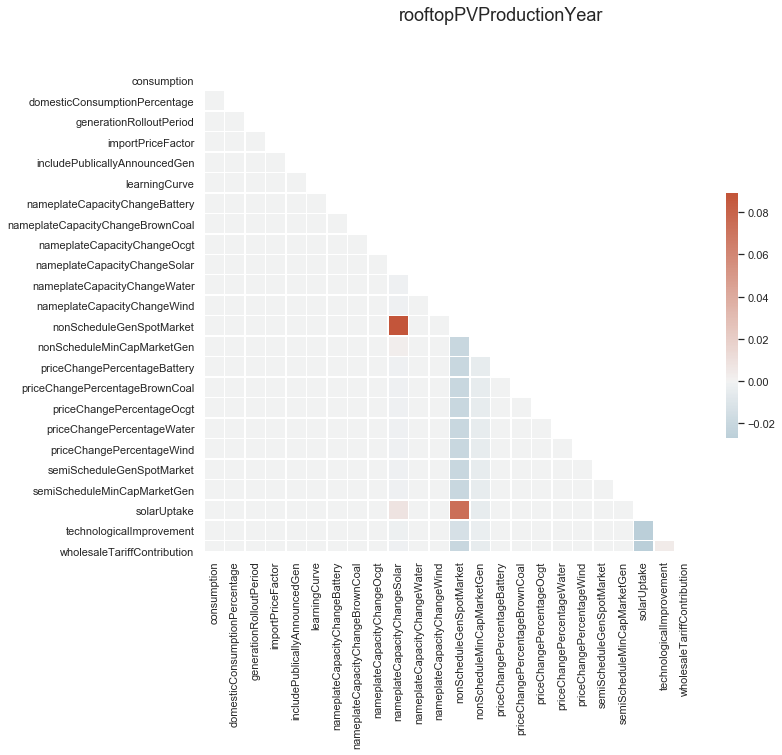

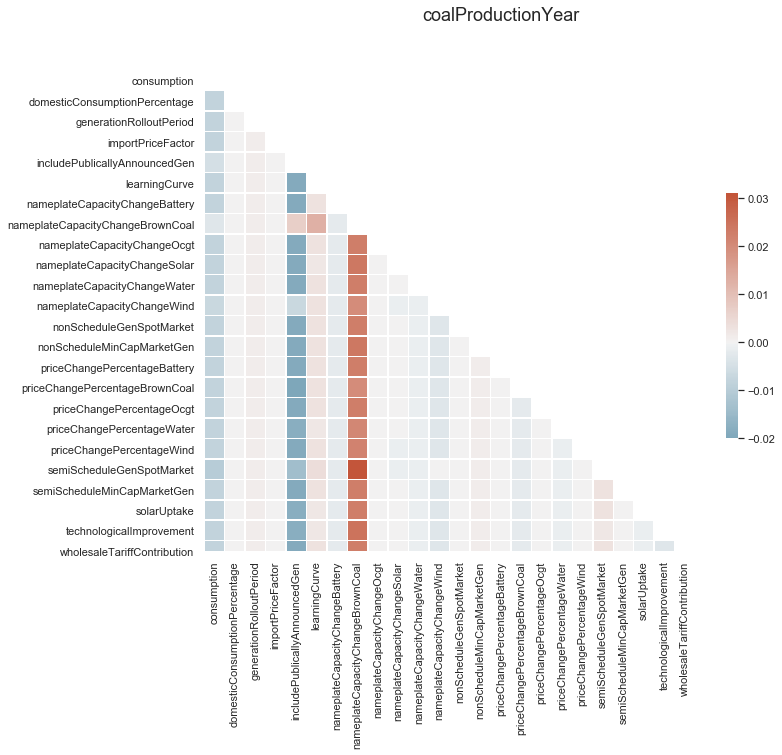

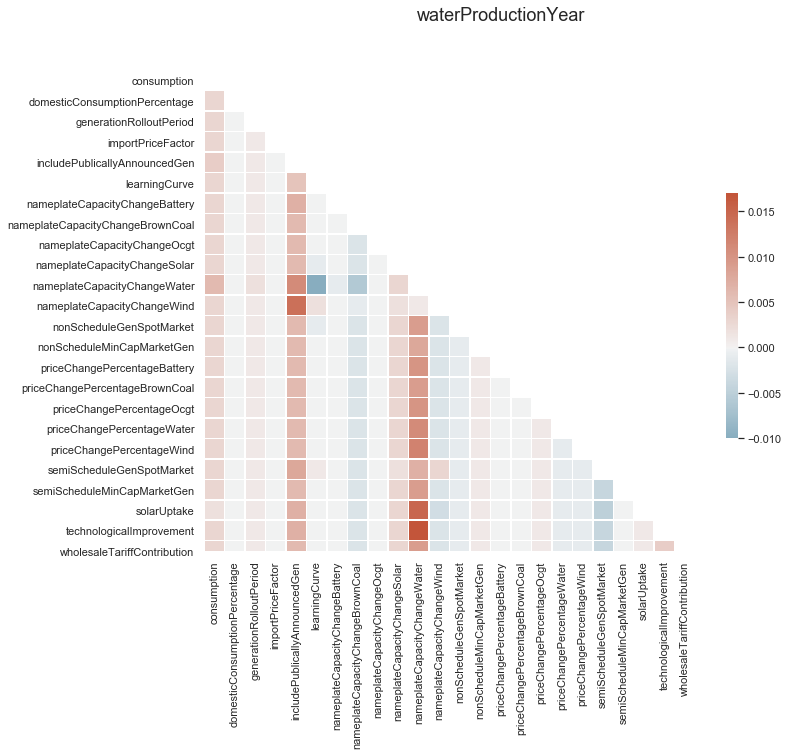

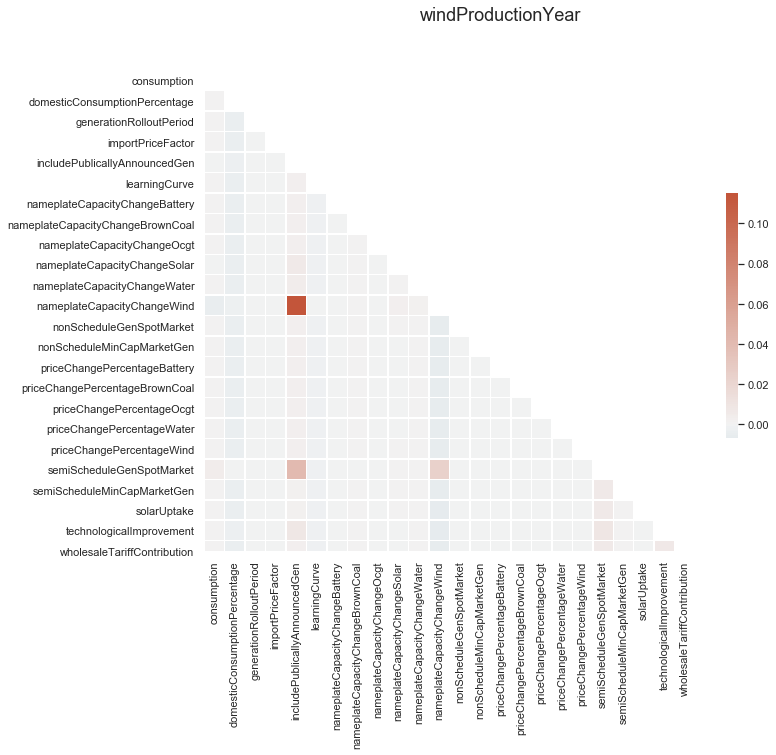

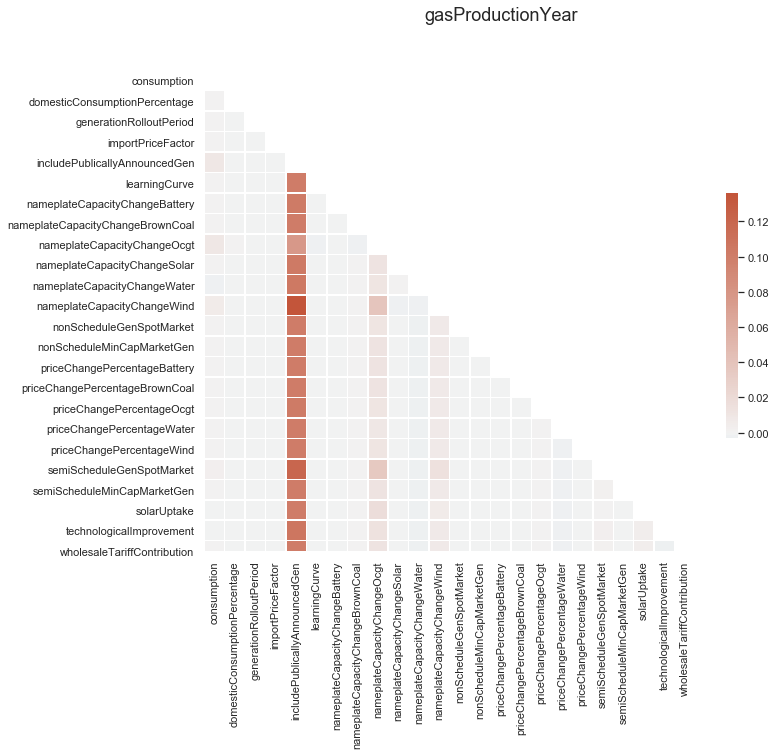

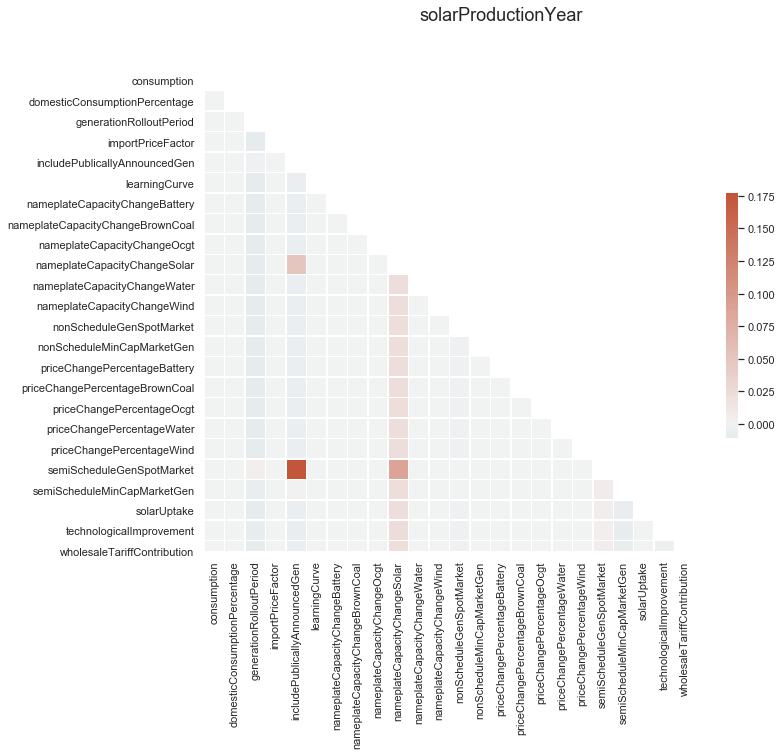

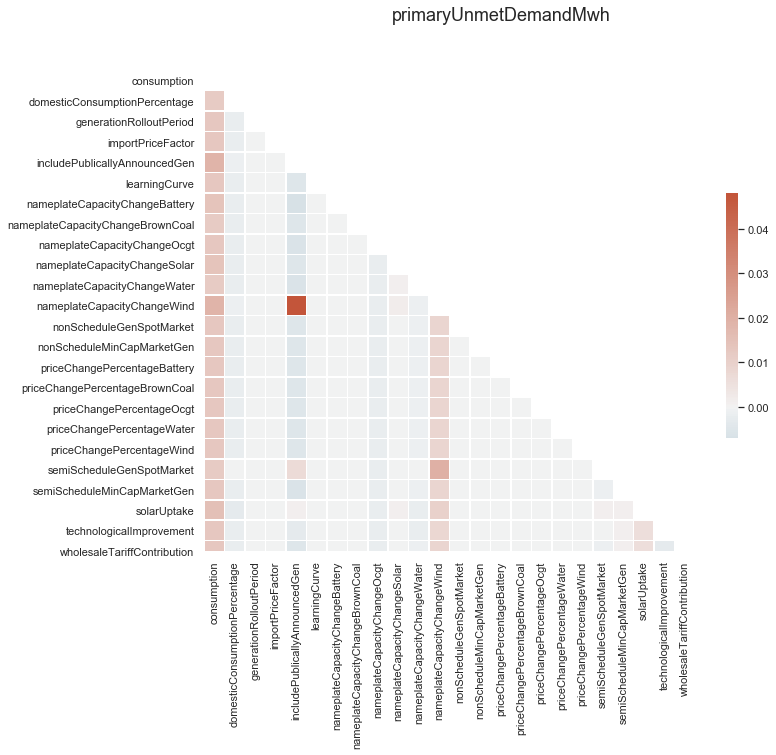

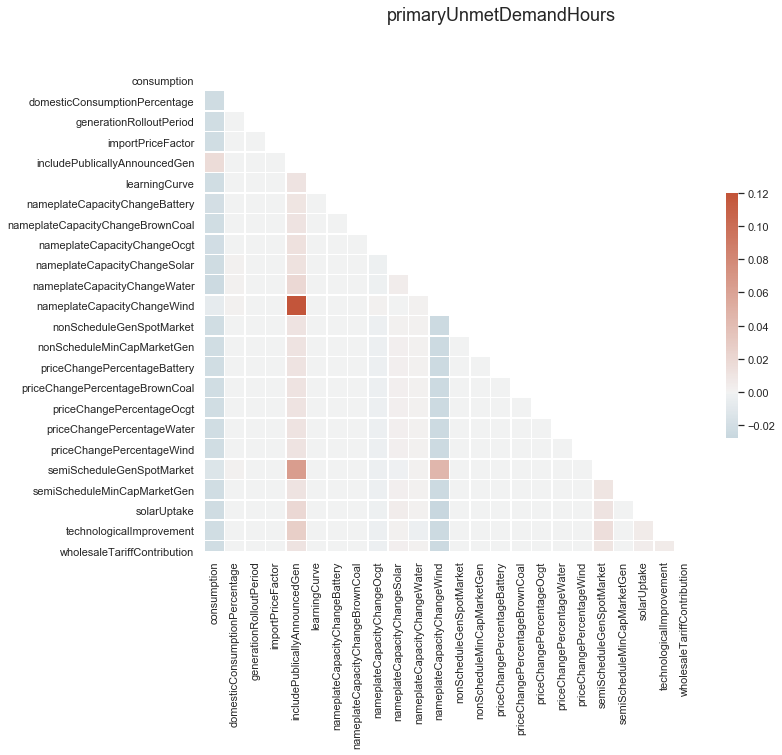

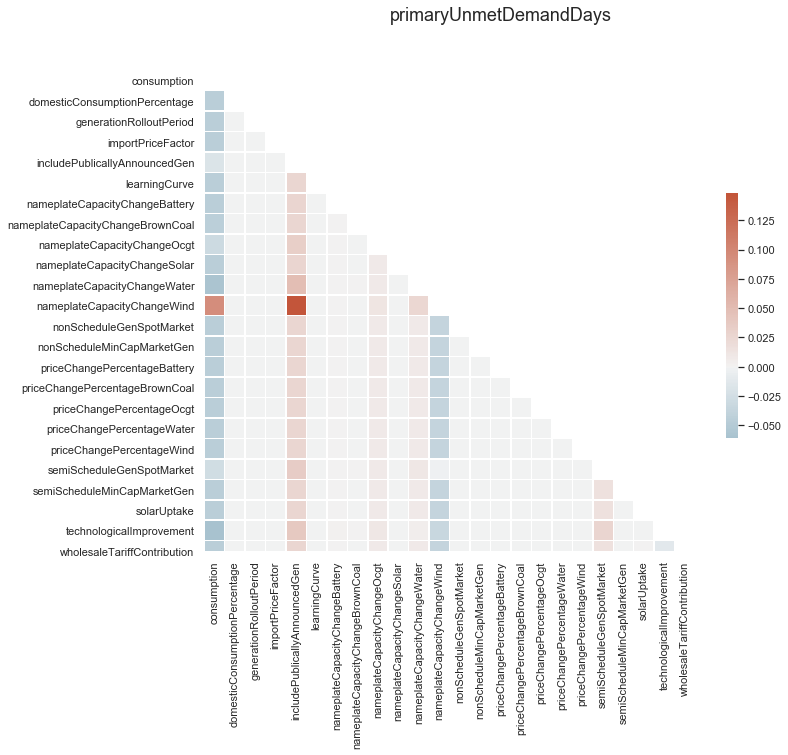

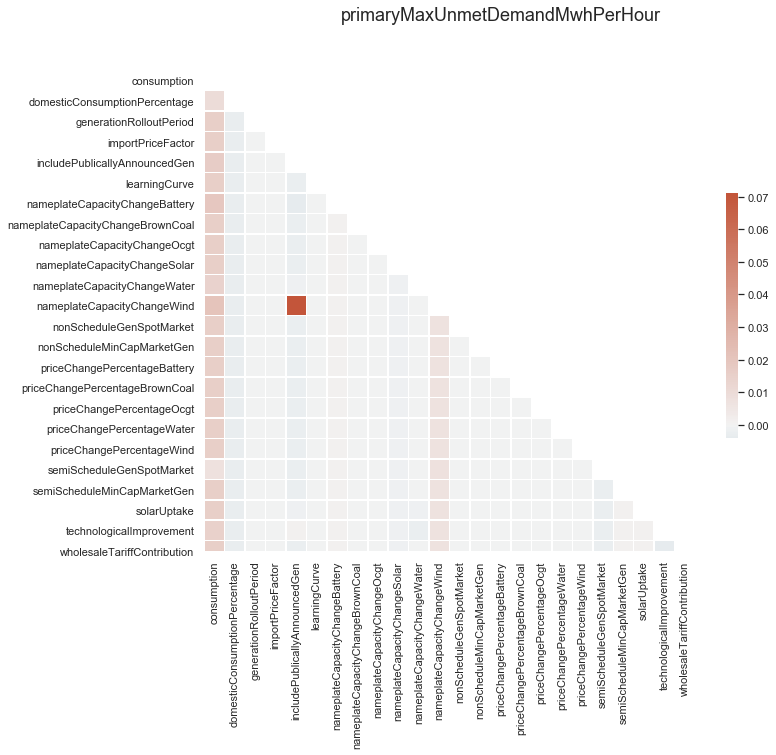

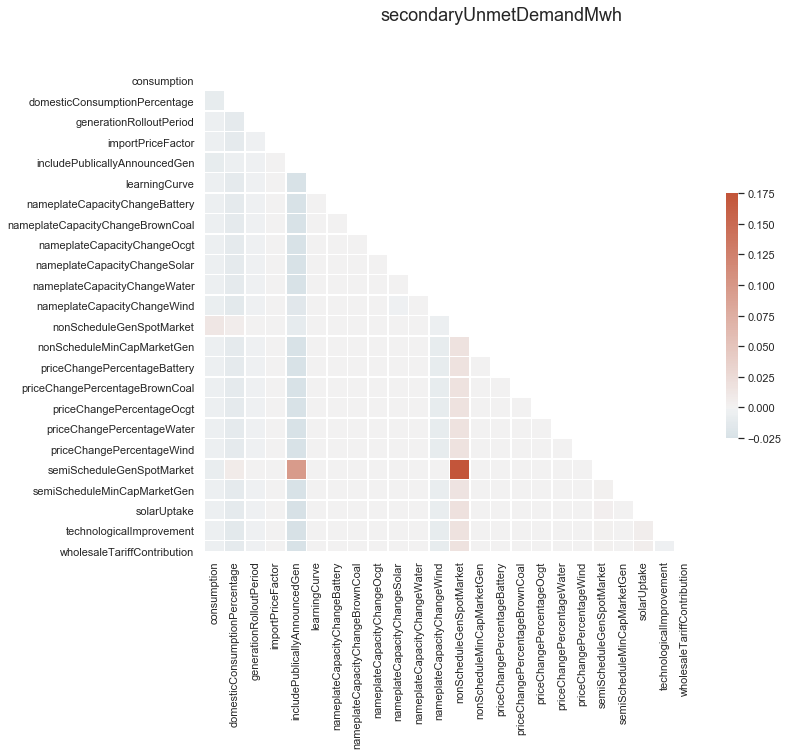

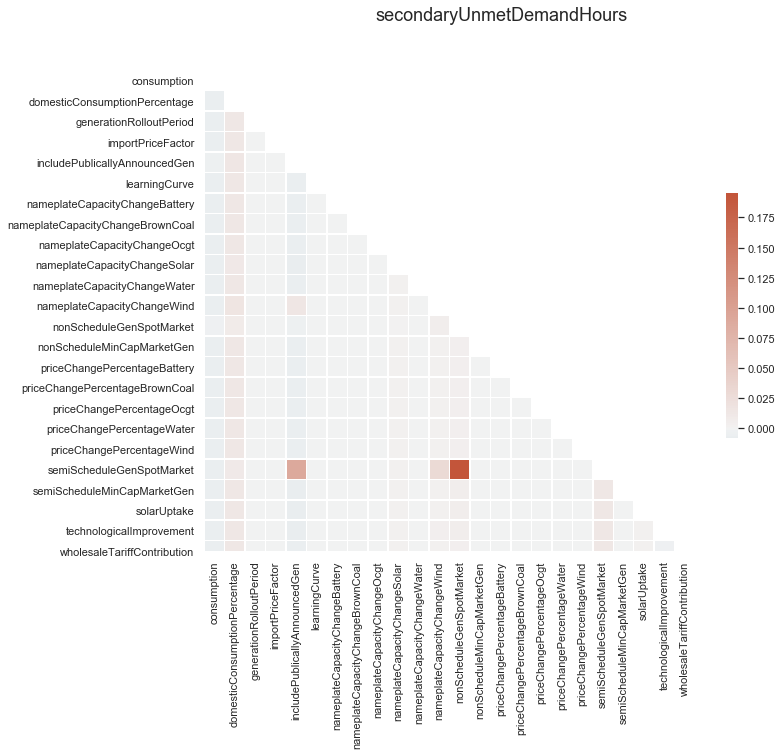

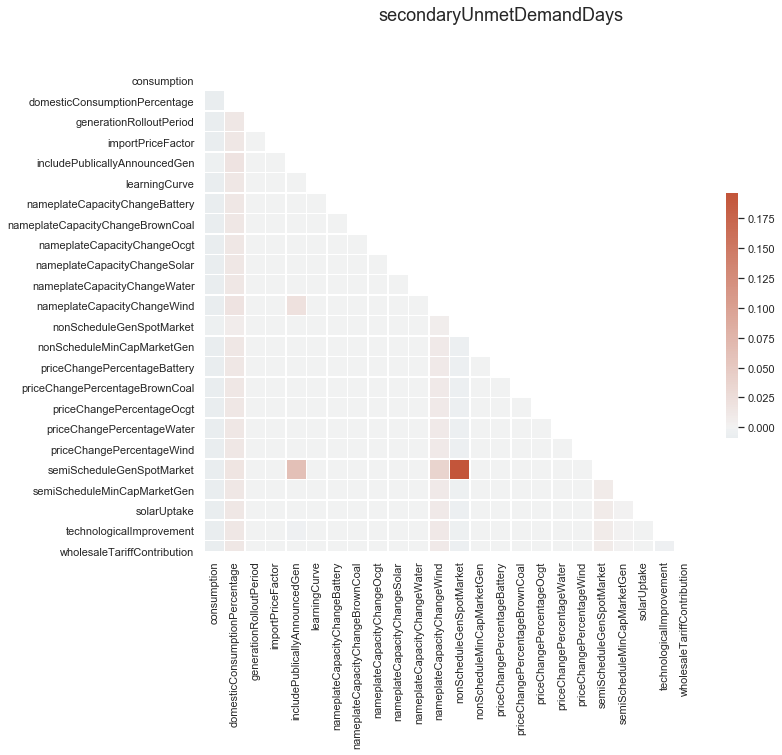

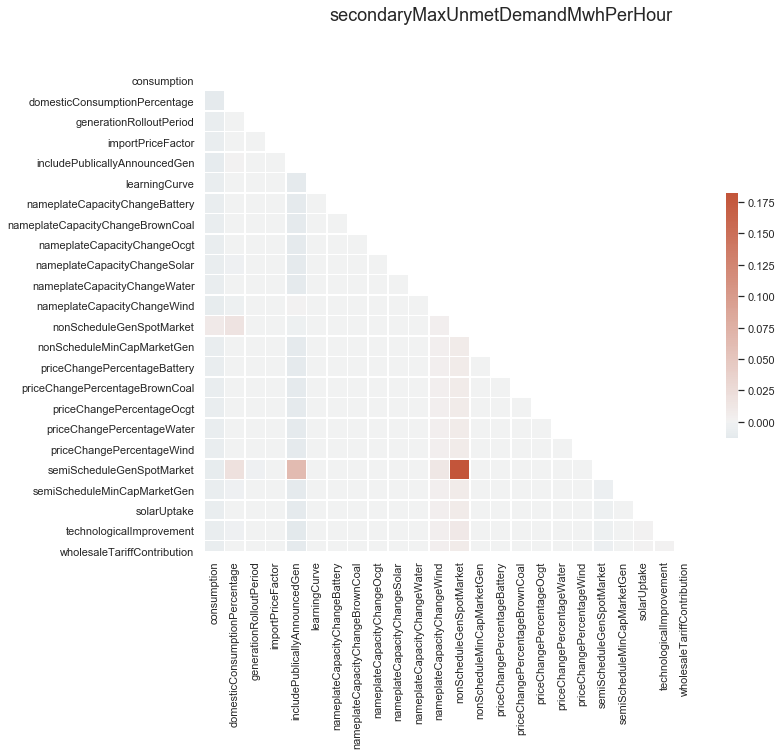

In [13]:
sns.set_style("whitegrid")
includePlots=True


if includePlots:
    for ooi in outcomes_to_show:
        corr = s2_median_ooi[ooi]
        corr = corr.round(3)

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        # Draw the heatmap
        sns.heatmap(corr.T, cmap=cmap, vmin=corr.min(axis=1).min(),vmax=corr.max(axis=1).max(), center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        f.suptitle(ooi, fontsize=18)
   
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_past_sobol_s2_median_%s'%(ooi)),dpi=300, bbox_inches='tight')


## Boxplot

In [14]:
# includePlots=True
# if includePlots:
#     for ooi in outcomes_to_show:
#         corr = s2_average_ooi[ooi]

#         # Set up the matplotlib figure
#         f, ax = plt.subplots(figsize=(11, 9))

#         # Generate a custom diverging colormap
#         cmap = sns.diverging_palette(230, 20, as_cmap=True)

#         # Draw the heatmap
#         sns.heatmap(corr.T, cmap=cmap, vmin=corr.min(axis=1).min(),vmax=corr.max(axis=1).max(), center=0,
#                     square=True, linewidths=.5, cbar_kws={"shrink": .5})
#         f.suptitle(ooi)
#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_s2_avg_%s'%(ooi)),dpi=300, bbox_inches='tight')

